# Land Patches

## 1. EDA

Analizam:
- echilibrul claselor (train/test),
- variabilitate intra-clasă și inter-clasă (vizual + măsuri simple),
- particularități relevante pentru antrenare (normalizare, augmentări, riscuri de bias/shortcut, integritatea datelor).


In [1]:
from pathlib import Path
import random, numpy as np, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [2]:
DATA_ROOT = Path("/kaggle/input/land-patches-final/land_patches")

TRAIN_DIR = DATA_ROOT / "train"
VAL_DIR   = DATA_ROOT / "val"
TEST_DIR  = DATA_ROOT / "test"

print("Exists:", TRAIN_DIR.exists(), VAL_DIR.exists(), TEST_DIR.exists())
print("Train classes:", len([p for p in TRAIN_DIR.iterdir() if p.is_dir()]))
print("Example class folders:", [p.name for p in TRAIN_DIR.iterdir() if p.is_dir()][:5])


Exists: True True True
Train classes: 10
Example class folders: ['SeaLake', 'Highway', 'River', 'Pasture', 'Industrial']


In [3]:
CLASSES = sorted([p.name for p in TRAIN_DIR.iterdir() if p.is_dir()])
CLASSES

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [4]:
IMG_EXT = {".jpg"}

def scan_split(split_dir: Path, split_name: str):
    rows = []
    classes = sorted([p.name for p in split_dir.iterdir() if p.is_dir()])
    for cls in classes:
        for p in (split_dir/cls).rglob("*"):
            if p.suffix.lower() in IMG_EXT:
                rows.append({"path": p, "split": split_name, "label": cls})
    return rows

rows = []
rows += scan_split(TRAIN_DIR, "train")
rows += scan_split(VAL_DIR,   "val")
rows += scan_split(TEST_DIR,  "test")

df = pd.DataFrame(rows)
df.head(), df.shape


(                                                path  split       label
 0  /kaggle/input/land-patches-final/land_patches/...  train  AnnualCrop
 1  /kaggle/input/land-patches-final/land_patches/...  train  AnnualCrop
 2  /kaggle/input/land-patches-final/land_patches/...  train  AnnualCrop
 3  /kaggle/input/land-patches-final/land_patches/...  train  AnnualCrop
 4  /kaggle/input/land-patches-final/land_patches/...  train  AnnualCrop,
 (10000, 3))

- Echilibrul claselor



In [5]:
counts = df.groupby(["split","label"]).size().unstack(0).fillna(0).astype(int)
counts

split                 test  train  val
label                                 
AnnualCrop             700    200  100
Forest                 700    200  100
HerbaceousVegetation   700    200  100
Highway                700    200  100
Industrial             700    200  100
Pasture                700    200  100
PermanentCrop          700    200  100
Residential            700    200  100
River                  700    200  100
SeaLake                700    200  100

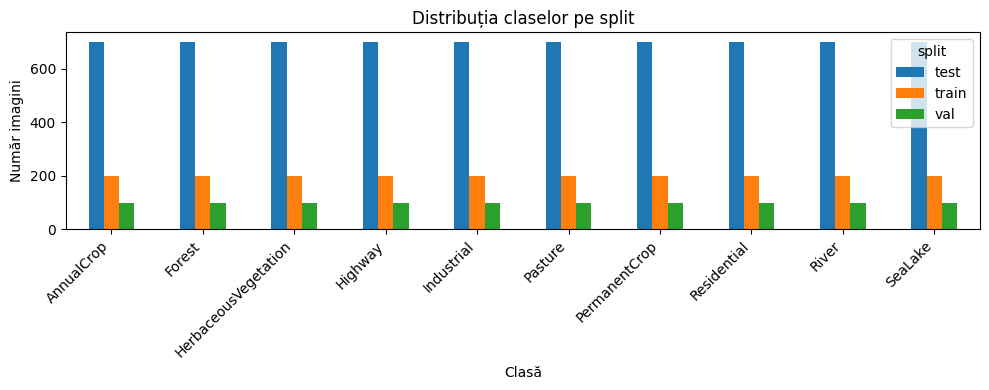

Total per split:
 split
test     7000
train    2000
val      1000
Name: count, dtype: int64
Min/Max per split:
 split
test     700
train    200
val      100
dtype: int64 
 split
test     700
train    200
val      100
dtype: int64


In [6]:
ax = counts.plot(kind="bar", figsize=(10,4))
ax.set_title("Distribuția claselor pe split")
ax.set_xlabel("Clasă")
ax.set_ylabel("Număr imagini")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print("Total per split:\n", df["split"].value_counts())
print("Min/Max per split:\n", counts.min(), "\n", counts.max())


- Integritatea datelor (sanity checks)


In [7]:
def safe_open(p: Path):
    try:
        with Image.open(p) as im:
            im.load()
            return im.size, im.mode, None
    except Exception as e:
        return None, None, str(e)

sample = df.sample(min(500, len(df)), random_state=RANDOM_SEED)
sizes, modes, errs = [], [], []

for p in sample["path"]:
    size, mode, err = safe_open(p)
    if err is not None:
        errs.append((p, err))
    else:
        sizes.append(size)
        modes.append(mode)

print("Erori (sample):", len(errs))
print("Dimensiuni unice (sample):", sorted(set(sizes))[:10], " | total:", len(set(sizes)))
print("Moduri unice (sample):", sorted(set(modes)))


Erori (sample): 0
Dimensiuni unice (sample): [(64, 64)]  | total: 1
Moduri unice (sample): ['RGB']


Variabilitatea intra si inter clasa:
- Inter-clasa:
    - SeaLake / River: domina nuante de albastru si verde
    - Forest: textura relativ uniforma dar granulara + tonuri verzi inchise
    - Industrial / Residential: multe margini, structuri geometrice, patch-uri mici, contrast mai mare
    - Highway: linii lungi (drumuri), structuri subtiri, diagonale
    - AnnualCrop / PermanentCrop / Pasture / HerbaceousVegetation: toate sunt cu vegetatie, dar difera prin patternuri

- Intra-clasa:
    - iluminare / sezonalitate (tonuri diferite),
    - cadrare (uneori obiectul/clasa domina tot patch-ul)
    - textura - River: uneori rau clar, alteori doar o zona albastra mare
    - scala unele patch-uri au detaliu fin, altele sunt mai omogene


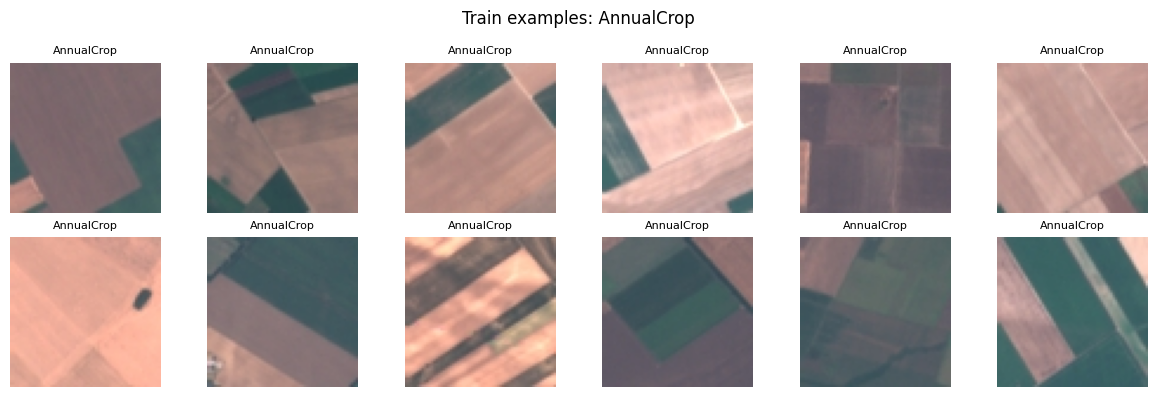

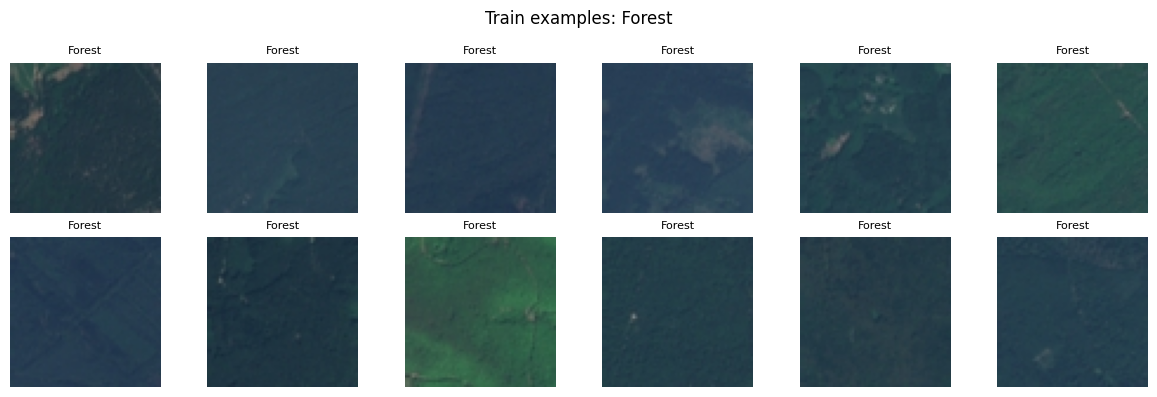

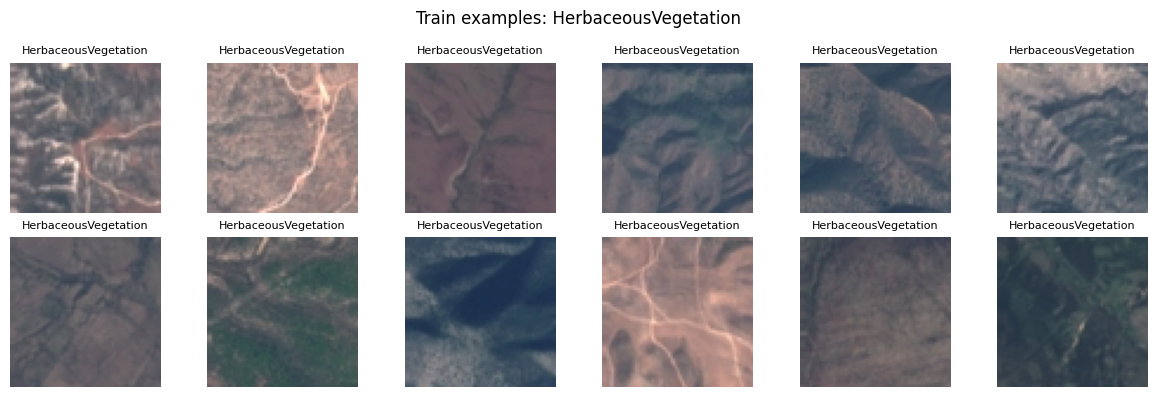

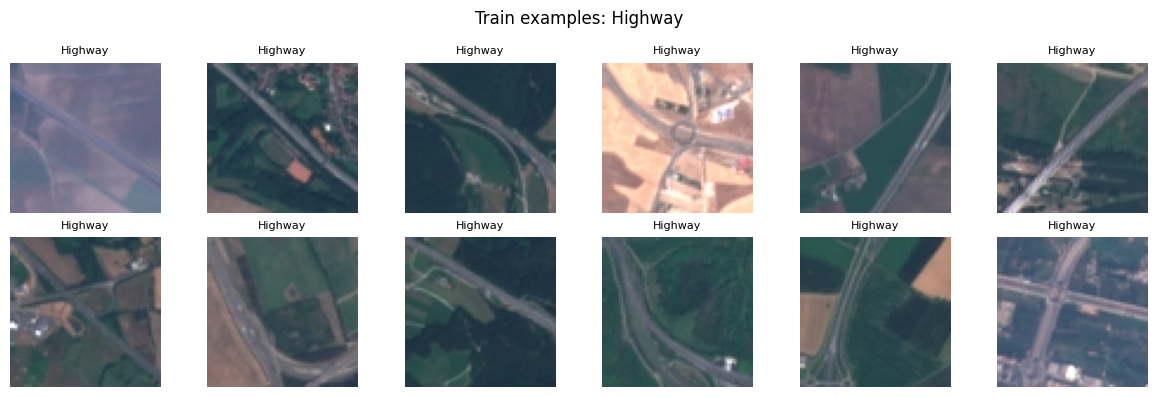

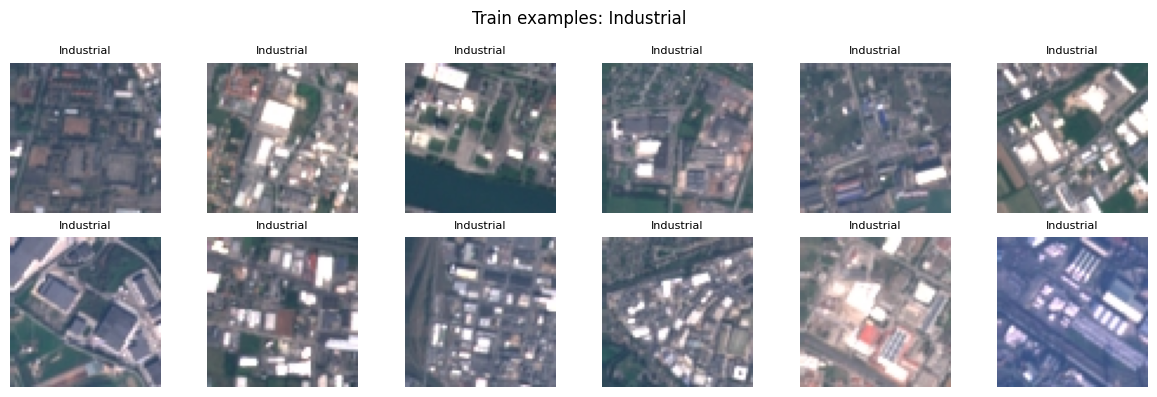

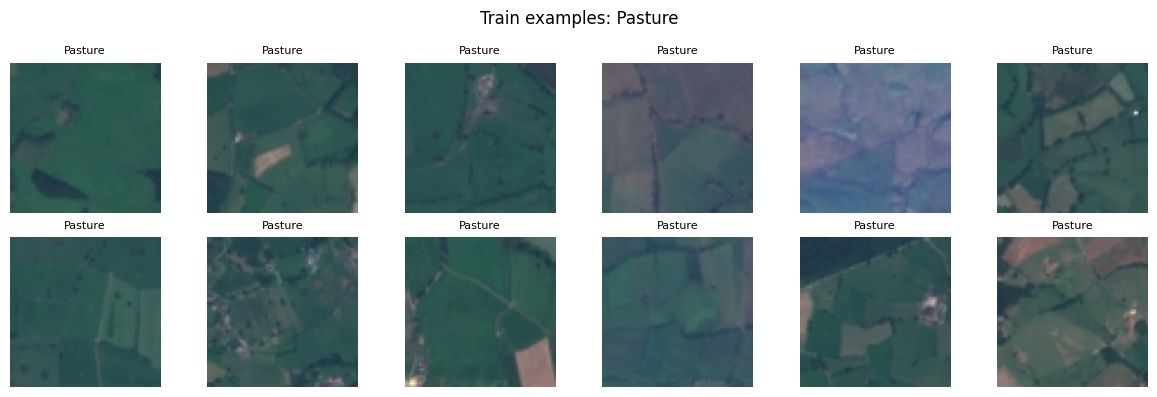

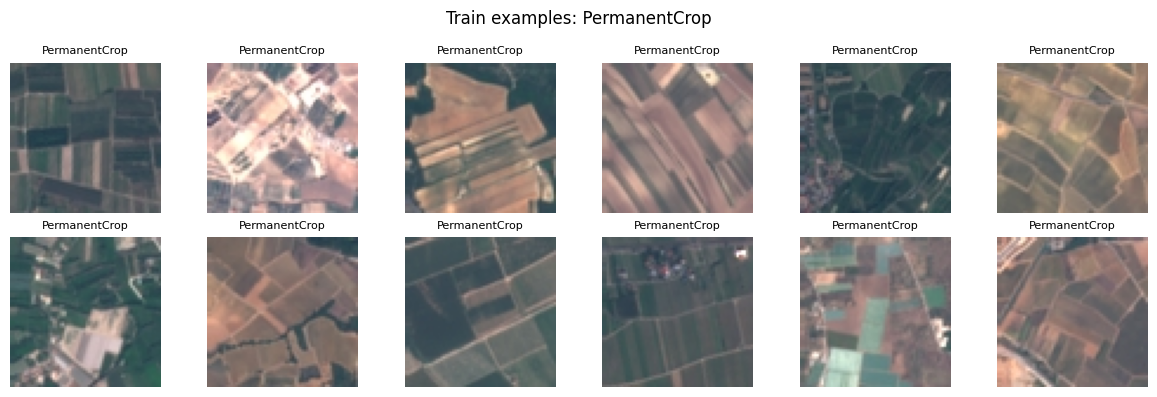

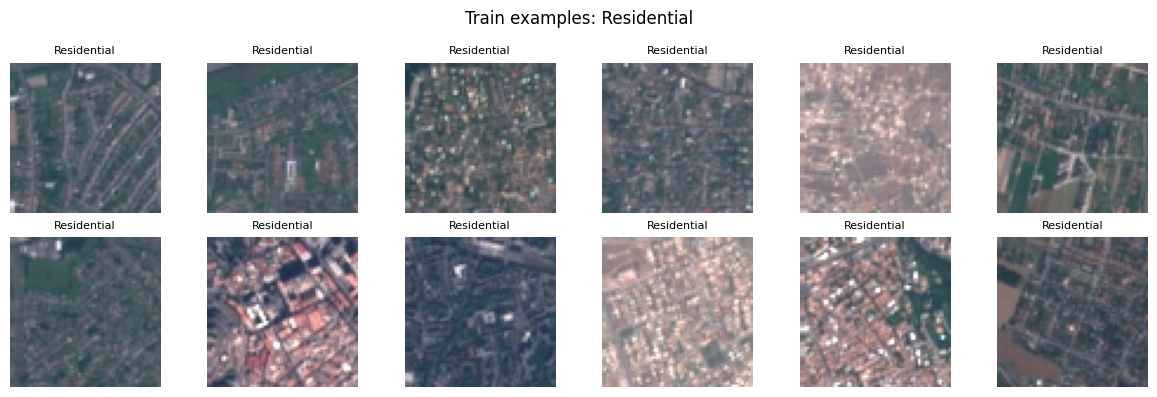

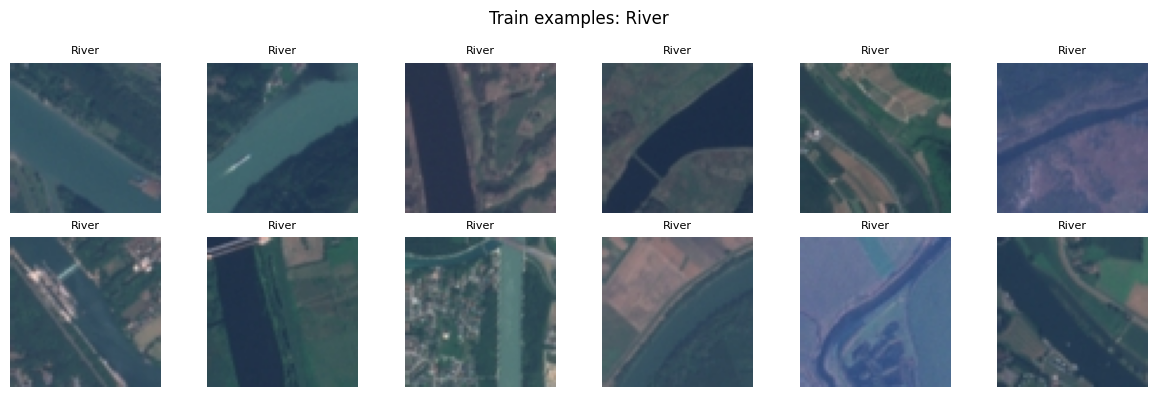

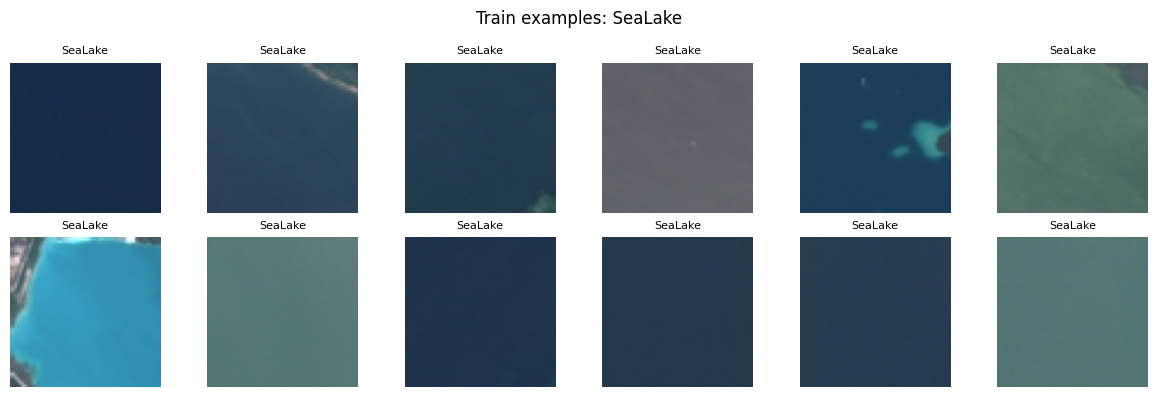

In [ ]:
def show_grid(paths, title="", cols=8):
    paths = list(paths)
    rows = (len(paths) + cols - 1) // cols
    plt.figure(figsize=(cols*2, rows*2))
    for i, p in enumerate(paths, 1):
        im = Image.open(p).convert("RGB")
        plt.subplot(rows, cols, i)
        plt.imshow(im)
        plt.axis("off")
        plt.title(p.parent.name, fontsize=8)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

for label in CLASSES:
    paths = df[(df.split=="train") & (df.label==label)].sample(12, random_state=RANDOM_SEED)["path"]
    show_grid(paths, title=f"Train examples: {label}", cols=6)


In [ ]:
def streaming_mean_std(paths, max_images=None):
    paths = list(paths)
    if max_images is not None:
        paths = random.sample(paths, min(max_images, len(paths)))

    n = 0
    s = np.zeros(3, dtype=np.float64)
    ss = np.zeros(3, dtype=np.float64)

    for p in tqdm(paths, desc="Mean/Std"):
        im = Image.open(p).convert("RGB")
        x = np.asarray(im, dtype=np.float32) / 255.0
        x = x.reshape(-1,3)
        s  += x.sum(axis=0)
        ss += (x**2).sum(axis=0)
        n  += x.shape[0]

    mean = s / n
    var = ss / n - mean**2
    std = np.sqrt(np.maximum(var, 0))
    return mean, std

train_paths = df[df.split=="train"]["path"]
mean_rgb, std_rgb = streaming_mean_std(train_paths, max_images=None)
mean_rgb, std_rgb


Mean/Std:   0%|          | 0/2000 [00:00<?, ?it/s]

(array([0.34831274, 0.38462076, 0.41126947]),
 array([0.20585178, 0.13901375, 0.1184202 ]))

BC stats:   0%|          | 0/3000 [00:00<?, ?it/s]

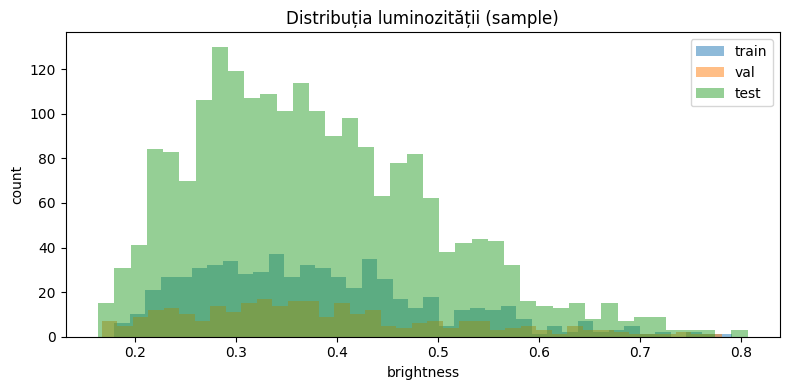

In [10]:
def brightness_contrast(p: Path):
    im = Image.open(p).convert("RGB")
    x = np.asarray(im, dtype=np.float32) / 255.0
    return float(x.mean()), float(x.std())

df_bc = df.sample(min(3000, len(df)), random_state=RANDOM_SEED).copy()
bc = np.array([brightness_contrast(p) for p in tqdm(df_bc["path"], desc="BC stats")])
df_bc["brightness"] = bc[:,0]
df_bc["contrast"] = bc[:,1]

plt.figure(figsize=(8,4))
for split in ["train","val","test"]:
    subset = df_bc[df_bc.split==split]
    plt.hist(subset["brightness"], bins=40, alpha=0.5, label=split)
plt.title("Distribuția luminozității (sample)")
plt.xlabel("brightness"); plt.ylabel("count")
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
df_bc.groupby("split")["brightness"].agg(["mean","std","min","max","median"]).round(3)


mean    std    min    max  median
split                                    
test   0.379  0.119  0.164  0.806   0.363
train  0.381  0.119  0.180  0.792   0.365
val    0.383  0.134  0.167  0.782   0.363

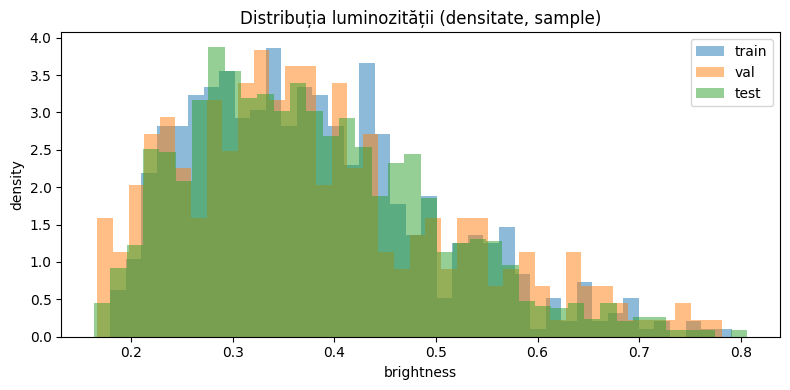

In [12]:
plt.figure(figsize=(8,4))
for split in ["train","val","test"]:
    subset = df_bc[df_bc.split==split]
    plt.hist(subset["brightness"], bins=40, alpha=0.5, label=split, density=True)
plt.title("Distribuția luminozității (densitate, sample)")
plt.xlabel("brightness"); plt.ylabel("density")
plt.legend()
plt.tight_layout()
plt.show()


River hist:   0%|          | 0/200 [00:00<?, ?it/s]

SeaLake hist:   0%|          | 0/200 [00:00<?, ?it/s]

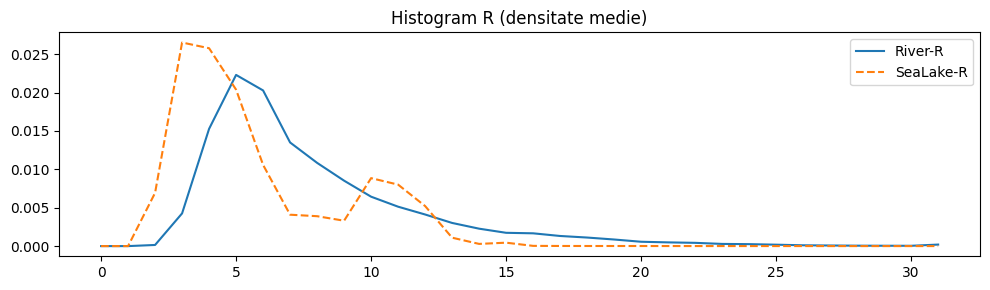

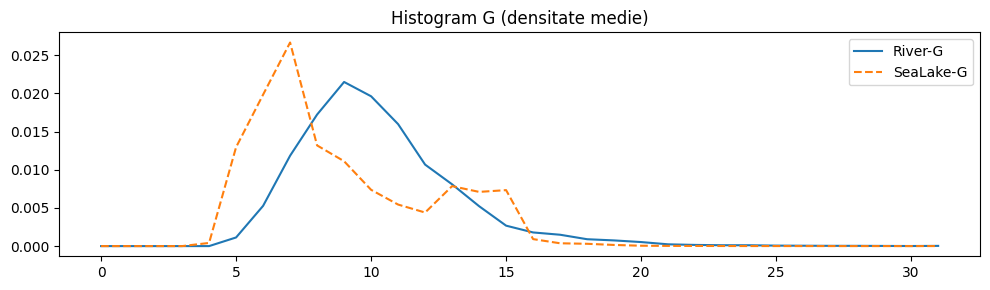

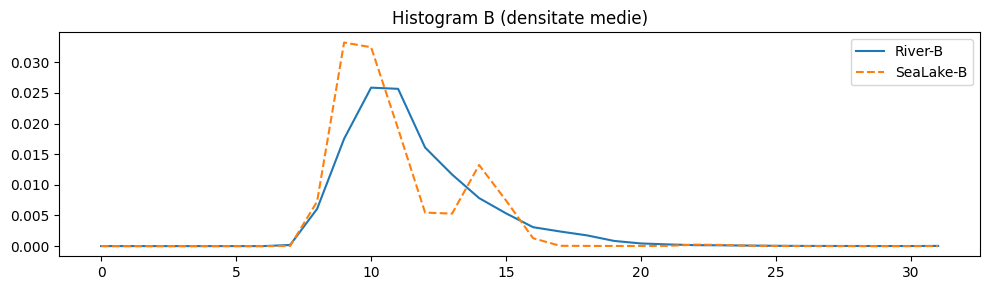

In [13]:
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

def mean_rgb_hist_for_class(df, label, split="train", bins=32, max_images=300):
    subset = df[(df.split==split) & (df.label==label)]
    subset = subset.sample(min(max_images, len(subset)), random_state=RANDOM_SEED)

    hR = np.zeros(bins); hG = np.zeros(bins); hB = np.zeros(bins)
    for p in tqdm(subset["path"], desc=f"{label} hist"):
        x = np.asarray(Image.open(p).convert("RGB"))
        r,g,b = x[:,:,0].ravel(), x[:,:,1].ravel(), x[:,:,2].ravel()
        hr,_ = np.histogram(r, bins=bins, range=(0,255), density=True)
        hg,_ = np.histogram(g, bins=bins, range=(0,255), density=True)
        hb,_ = np.histogram(b, bins=bins, range=(0,255), density=True)
        hR += hr; hG += hg; hB += hb

    n = len(subset)
    return hR/n, hG/n, hB/n

def plot_two_classes_hist(df, c1, c2, bins=32):
    h1 = mean_rgb_hist_for_class(df, c1, bins=bins)
    h2 = mean_rgb_hist_for_class(df, c2, bins=bins)
    xs = np.arange(bins)

    plt.figure(figsize=(10,3))
    plt.plot(xs, h1[0], label=f"{c1}-R"); plt.plot(xs, h2[0], label=f"{c2}-R", linestyle="--")
    plt.title("Histogram R (densitate medie)")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,3))
    plt.plot(xs, h1[1], label=f"{c1}-G"); plt.plot(xs, h2[1], label=f"{c2}-G", linestyle="--")
    plt.title("Histogram G (densitate medie)")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,3))
    plt.plot(xs, h1[2], label=f"{c1}-B"); plt.plot(xs, h2[2], label=f"{c2}-B", linestyle="--")
    plt.title("Histogram B (densitate medie)")
    plt.legend(); plt.tight_layout(); plt.show()

plot_two_classes_hist(df, "River", "SeaLake", bins=32)


In [14]:
import numpy as np
from PIL import Image
from tqdm.auto import tqdm

def edge_strength(p):
    im = Image.open(p).convert("L")
    x = np.asarray(im, dtype=np.float32) / 255.0

    gx = np.abs(np.diff(x, axis=1))
    gy = np.abs(np.diff(x, axis=0))

    g = 0.5 * (gx.mean() + gy.mean())
    return float(g)

def edge_stats_for_class(df, label, split="train", n=400):
    subset = df[(df.split==split) & (df.label==label)]
    subset = subset.sample(min(n, len(subset)), random_state=RANDOM_SEED)

    vals = [edge_strength(p) for p in tqdm(subset["path"], desc=f"edges {label}")]
    return np.array(vals), subset["path"].tolist()


edges River:   0%|          | 0/200 [00:00<?, ?it/s]

edges SeaLake:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_55/1559134897.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([river_vals, sea_vals], labels=["River", "SeaLake"])


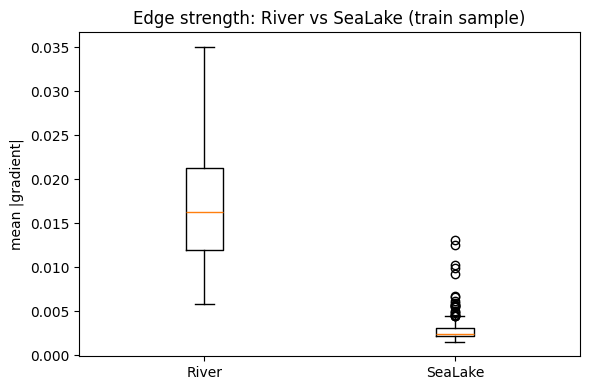

River  mean/std: 0.017058475986123086 0.006208311866726715
SeaLake mean/std: 0.002987412002403289 0.001636075931987621


In [15]:
river_vals, river_paths = edge_stats_for_class(df, "River", split="train", n=400)
sea_vals, sea_paths     = edge_stats_for_class(df, "SeaLake", split="train", n=400)

plt.figure(figsize=(6,4))
plt.boxplot([river_vals, sea_vals], labels=["River", "SeaLake"])
plt.title("Edge strength: River vs SeaLake (train sample)")
plt.ylabel("mean |gradient|")
plt.tight_layout()
plt.show()

print("River  mean/std:", river_vals.mean(), river_vals.std())
print("SeaLake mean/std:", sea_vals.mean(), sea_vals.std())


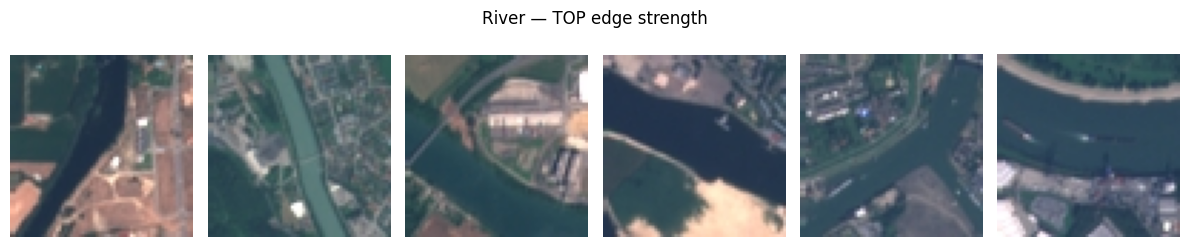

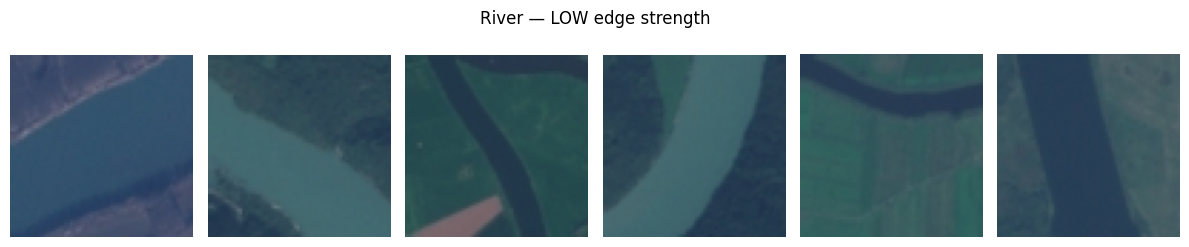

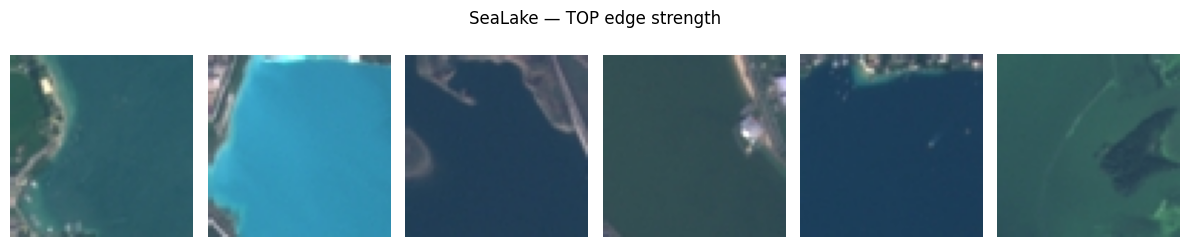

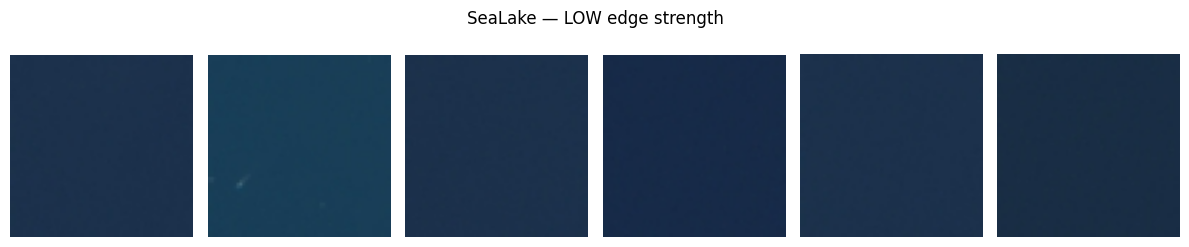

In [ ]:
def show_examples_by_score(paths, scores, title, k=8):
    idx = np.argsort(scores)[::-1]
    top = [paths[i] for i in idx[:k]]
    bot = [paths[i] for i in idx[-k:]]
    
    def show_grid(paths, title):
        cols = k
        plt.figure(figsize=(cols*2, 2.5))
        for i, p in enumerate(paths, 1):
            im = Image.open(p).convert("RGB")
            plt.subplot(1, cols, i)
            plt.imshow(im); plt.axis("off")
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()

    show_grid(top, title + " — TOP edge strength")
    show_grid(bot, title + " — LOW edge strength")

show_examples_by_score(river_paths, river_vals, "River", k=6)
show_examples_by_score(sea_paths, sea_vals, "SeaLake", k=6)


In [ ]:
rows = []
for label in CLASSES:
    subset = df[(df.split=="train") & (df.label==label)].sample(200, random_state=RANDOM_SEED)
    vals = [edge_strength(p) for p in subset["path"]]
    rows.append({"label": label, "edge_density_mean": np.mean(vals), "edge_density_std": np.std(vals)})

ed = pd.DataFrame(rows).sort_values("edge_density_mean", ascending=False)
ed


label  edge_density_mean  edge_density_std
4            Industrial           0.052876          0.009439
7           Residential           0.044432          0.015403
6         PermanentCrop           0.027860          0.010113
3               Highway           0.023468          0.009364
2  HerbaceousVegetation           0.021670          0.012822
8                 River           0.017058          0.006208
0            AnnualCrop           0.013458          0.005433
5               Pasture           0.010279          0.002974
1                Forest           0.007366          0.002100
9               SeaLake           0.002987          0.001636

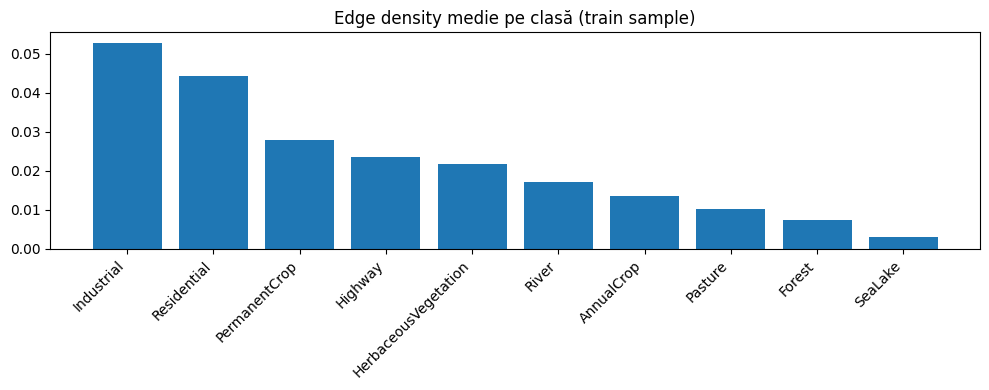

In [22]:
plt.figure(figsize=(10,4))
plt.bar(ed["label"], ed["edge_density_mean"])
plt.title("Edge density medie pe clasă (train sample)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# 2. MLP pe Land Patches

1) Construim un baseline MLP pentru clasificare
2) Comparam antrenarea fara augmentări vs. cu augmentări (Albumentations) pe aceleași grafice.


In [32]:
import os, random
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

RANDOM_SEED = 42
def seed_everything(seed=RANDOM_SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False

seed_everything()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [33]:
LAND_ROOT = Path("/kaggle/input/land-patches-final/land_patches")

def build_df_from_folders(root: Path):
    rows = []
    for split in ["train", "val", "test"]:
        split_dir = root / split
        for cls_dir in sorted([p for p in split_dir.iterdir() if p.is_dir()]):
            label = cls_dir.name
            for p in cls_dir.glob("*"):
                if p.suffix.lower() in [".jpg"]:
                    rows.append({"path": p, "label": label, "split": split})
    return pd.DataFrame(rows)

df = build_df_from_folders(LAND_ROOT)
df.head(), df["split"].value_counts()


(                                                path       label  split
 0  /kaggle/input/land-patches-final/land_patches/...  AnnualCrop  train
 1  /kaggle/input/land-patches-final/land_patches/...  AnnualCrop  train
 2  /kaggle/input/land-patches-final/land_patches/...  AnnualCrop  train
 3  /kaggle/input/land-patches-final/land_patches/...  AnnualCrop  train
 4  /kaggle/input/land-patches-final/land_patches/...  AnnualCrop  train,
 split
 test     7000
 train    2000
 val      1000
 Name: count, dtype: int64)

In [34]:
CLASSES = sorted(df["label"].unique().tolist())
num_classes = len(CLASSES)
label_to_idx = {c:i for i,c in enumerate(CLASSES)}
id_to_name = {i:c for c,i in label_to_idx.items()}

num_classes, CLASSES[:5]


(10, ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial'])

label  AnnualCrop  Forest  HerbaceousVegetation  Highway  Industrial  Pasture  \
split                                                                           
test          700     700                   700      700         700      700   
train         200     200                   200      200         200      200   
val           100     100                   100      100         100      100   

label  PermanentCrop  Residential  River  SeaLake  
split                                              
test             700          700    700      700  
train            200          200    200      200  
val              100          100    100      100

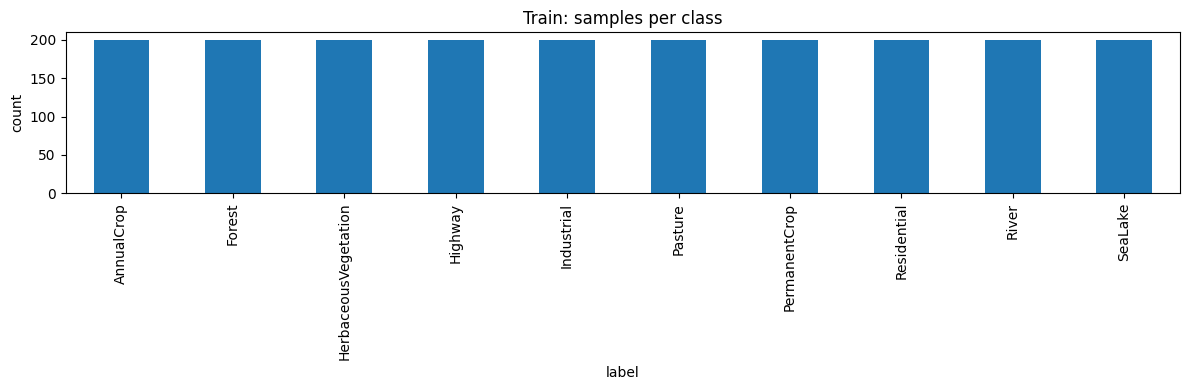

In [35]:
counts = df.groupby(["split","label"]).size().unstack(fill_value=0)
display(counts)

plt.figure(figsize=(12,4))
counts.loc["train"].sort_values(ascending=False).plot(kind="bar")
plt.title("Train: samples per class")
plt.ylabel("count")
plt.tight_layout()
plt.show()


In [36]:
from tqdm.auto import tqdm

def streaming_mean_std(paths, max_n=2000):
    paths = list(paths)
    if len(paths) > max_n:
        paths = np.random.RandomState(RANDOM_SEED).choice(paths, size=max_n, replace=False)

    n = 0
    mean = np.zeros(3, dtype=np.float64)
    M2 = np.zeros(3, dtype=np.float64)

    for p in tqdm(paths, desc="Mean/Std"):
        x = np.asarray(Image.open(p).convert("RGB"), dtype=np.float32) / 255.0  # HWC
        x = x.reshape(-1,3)
        n_batch = x.shape[0]

        batch_mean = x.mean(axis=0)
        batch_var  = x.var(axis=0)

        if n == 0:
            mean = batch_mean
            M2   = batch_var * n_batch
            n    = n_batch
        else:
            delta = batch_mean - mean
            tot_n = n + n_batch
            mean = mean + delta * (n_batch / tot_n)
            M2 = M2 + batch_var * n_batch + (delta**2) * (n * n_batch / tot_n)
            n = tot_n

    std = np.sqrt(M2 / n)
    return mean.astype(np.float32), std.astype(np.float32)

train_paths = df[df.split=="train"]["path"].tolist()
mean_rgb, std_rgb = streaming_mean_std(train_paths, max_n=2000)
mean_rgb, std_rgb


Mean/Std:   0%|          | 0/2000 [00:00<?, ?it/s]

(array([0.34831274, 0.38462096, 0.41126928], dtype=float32),
 array([0.20585404, 0.13901883, 0.11842568], dtype=float32))

In [37]:
import albumentations as A
from torch.utils.data import Dataset

tfm_noaug_64 = A.Compose([
    A.Normalize(mean=mean_rgb.tolist(), std=std_rgb.tolist(), max_pixel_value=255.0),
])

tfm_aug_64 = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.10, rotate_limit=15, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05, p=0.5),
    A.Normalize(mean=mean_rgb.tolist(), std=std_rgb.tolist(), max_pixel_value=255.0),
])


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
class LandPatchesDataset(Dataset):
    def __init__(self, df, transform, flatten=True):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.flatten = flatten

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        p = self.df.loc[i, "path"]
        y = label_to_idx[self.df.loc[i, "label"]]

        img = np.array(Image.open(p).convert("RGB"))
        out = self.transform(image=img)["image"]      
        x = torch.from_numpy(out).permute(2,0,1).float() 

        if self.flatten:
            x = x.reshape(-1) 
        return x, torch.tensor(y, dtype=torch.long)

dummy_x, _ = LandPatchesDataset(df[df.split=="train"].head(1), tfm_noaug_64, flatten=False)[0]
print(dummy_x.shape)

dummy_x, _ = LandPatchesDataset(df[df.split=="train"].head(1), tfm_noaug_64, flatten=True)[0]
print(dummy_x.shape)  
in_dim = dummy_x.numel()
print("in_dim =", in_dim)



torch.Size([3, 64, 64])
torch.Size([12288])
in_dim = 12288


In [ ]:
BATCH_SIZE = 128

df_train = df[df.split=="train"].copy()
df_val   = df[df.split=="val"].copy()
df_test  = df[df.split=="test"].copy()

train_ds_noaug = LandPatchesDataset(df_train, tfm_noaug_64, flatten=True)
val_ds_noaug   = LandPatchesDataset(df_val,   tfm_noaug_64, flatten=True)

train_ds_aug   = LandPatchesDataset(df_train, tfm_aug_64,   flatten=True)
val_ds_aug     = LandPatchesDataset(df_val,   tfm_noaug_64, flatten=True)  

train_loader_noaug = DataLoader(train_ds_noaug, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader_noaug   = DataLoader(val_ds_noaug,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

train_loader_aug = DataLoader(train_ds_aug, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader_aug   = DataLoader(val_ds_aug,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


In [40]:
from sklearn.metrics import accuracy_score, f1_score

class MLP(nn.Module):
    def __init__(self, in_dim, num_classes, hidden1=512, hidden2=256, dropout=0.4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden1),
            nn.BatchNorm1d(hidden1),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),

            nn.Linear(hidden1, hidden2),
            nn.BatchNorm1d(hidden2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),

            nn.Linear(hidden2, num_classes)
        )

    def forward(self, x):
        return self.net(x)

def run_epoch(model, loader, optimizer=None):
    train = optimizer is not None
    model.train(train)

    criterion = nn.CrossEntropyLoss()
    losses = []
    all_y, all_p = [], []

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        if train:
            optimizer.zero_grad()

        logits = model(x)
        loss = criterion(logits, y)

        if train:
            loss.backward()
            optimizer.step()

        losses.append(loss.item())
        preds = logits.argmax(dim=1)

        all_y.append(y.detach().cpu().numpy())
        all_p.append(preds.detach().cpu().numpy())

    all_y = np.concatenate(all_y)
    all_p = np.concatenate(all_p)

    acc = accuracy_score(all_y, all_p)
    f1  = f1_score(all_y, all_p, average="macro")
    return float(np.mean(losses)), acc, f1

def train_model(train_loader, val_loader,
                hidden1=512, hidden2=256, dropout=0.4,
                epochs=50, lr=1e-3, weight_decay=1e-4,
                patience=7, min_delta=1e-4):

    model = MLP(in_dim=in_dim, num_classes=num_classes,
                hidden1=hidden1, hidden2=hidden2, dropout=dropout).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[], "train_f1":[], "val_f1":[]}

    best_val = -1.0
    best_state = None
    bad_epochs = 0

    for ep in range(1, epochs+1):
        tr_loss, tr_acc, tr_f1 = run_epoch(model, train_loader, optimizer=optimizer)
        va_loss, va_acc, va_f1 = run_epoch(model, val_loader, optimizer=None)

        history["train_loss"].append(tr_loss); history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc);   history["val_acc"].append(va_acc)
        history["train_f1"].append(tr_f1);     history["val_f1"].append(va_f1)

        improved = (va_f1 > best_val + min_delta)
        if improved:
            best_val = va_f1
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1

        print(f"Epoch {ep:02d} | train loss {tr_loss:.3f} acc {tr_acc:.3f} f1 {tr_f1:.3f} "
              f"| val loss {va_loss:.3f} acc {va_acc:.3f} f1 {va_f1:.3f} "
              f"| bad_epochs={bad_epochs}/{patience}")

        if bad_epochs >= patience:
            print(f"Early stopping: no val_f1 improvement for {patience} epochs. Best val_f1={best_val:.4f}")
            break

    model.load_state_dict(best_state)
    return model, history


In [41]:
configs = [
    dict(name="small", hidden1=512,  hidden2=256, dropout=0.4),
    dict(name="large", hidden1=1024, hidden2=512, dropout=0.3),
]

results = {}

for cfg in configs:
    print("NO-AUG |", cfg["name"])
    mlp_noaug, hist_noaug = train_model(
        train_loader_noaug, val_loader_noaug,
        hidden1=cfg["hidden1"], hidden2=cfg["hidden2"], dropout=cfg["dropout"],
        epochs=50, lr=1e-3, weight_decay=1e-4, patience=7
    )
    results[("noaug", cfg["name"])] = (mlp_noaug, hist_noaug)

    print("\n")
    print("AUG |", cfg["name"])
    mlp_aug, hist_aug = train_model(
        train_loader_aug, val_loader_aug,
        hidden1=cfg["hidden1"], hidden2=cfg["hidden2"], dropout=cfg["dropout"],
        epochs=50, lr=1e-3, weight_decay=1e-4, patience=7
    )
    results[("aug", cfg["name"])] = (mlp_aug, hist_aug)


NO-AUG | small
Epoch 01 | train loss 1.915 acc 0.306 f1 0.272 | val loss 1.868 acc 0.300 f1 0.225 | bad_epochs=0/7
Epoch 02 | train loss 1.624 acc 0.424 f1 0.400 | val loss 1.563 acc 0.452 f1 0.425 | bad_epochs=0/7
Epoch 03 | train loss 1.486 acc 0.464 f1 0.443 | val loss 1.406 acc 0.510 f1 0.484 | bad_epochs=0/7
Epoch 04 | train loss 1.386 acc 0.510 f1 0.491 | val loss 1.350 acc 0.526 f1 0.512 | bad_epochs=0/7
Epoch 05 | train loss 1.307 acc 0.541 f1 0.527 | val loss 1.282 acc 0.570 f1 0.552 | bad_epochs=0/7
Epoch 06 | train loss 1.251 acc 0.558 f1 0.543 | val loss 1.268 acc 0.568 f1 0.559 | bad_epochs=0/7
Epoch 07 | train loss 1.186 acc 0.593 f1 0.581 | val loss 1.276 acc 0.542 f1 0.529 | bad_epochs=1/7
Epoch 08 | train loss 1.137 acc 0.616 f1 0.607 | val loss 1.215 acc 0.566 f1 0.552 | bad_epochs=2/7
Epoch 09 | train loss 1.076 acc 0.622 f1 0.612 | val loss 1.239 acc 0.564 f1 0.553 | bad_epochs=3/7
Epoch 10 | train loss 1.048 acc 0.640 f1 0.632 | val loss 1.232 acc 0.556 f1 0.544 | 

In [42]:
def best_key(split_name):
    best = None
    best_f1 = -1
    for (split, name), (_, hist) in results.items():
        if split != split_name: 
            continue
        m = max(hist["val_f1"])
        if m > best_f1:
            best_f1 = m
            best = (split, name)
    return best, best_f1

best_noaug_key, best_noaug_f1 = best_key("noaug")
best_aug_key,   best_aug_f1   = best_key("aug")
best_noaug_key, best_noaug_f1, best_aug_key, best_aug_f1


(('noaug', 'large'), 0.5825356018823439, ('aug', 'small'), 0.6082608779472903)

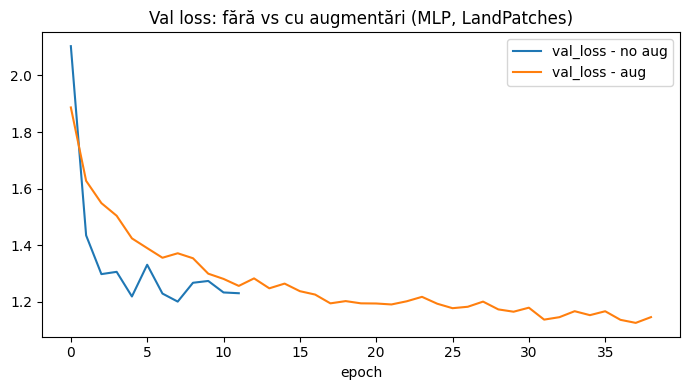

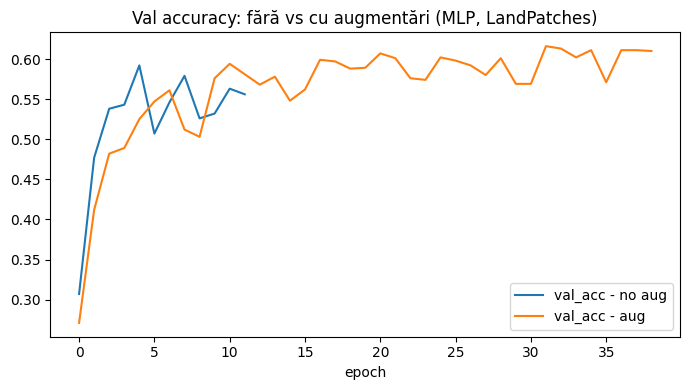

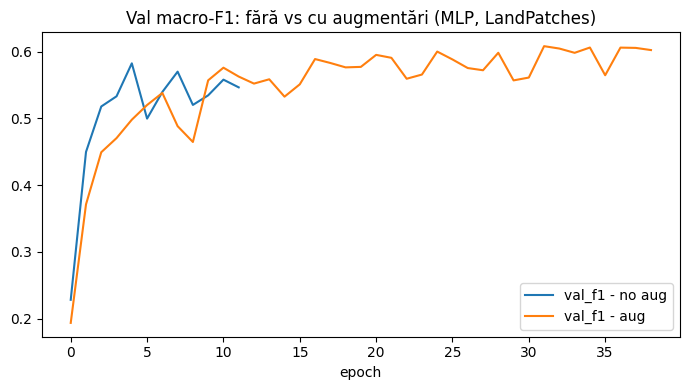

In [43]:
def plot_compare(hist1, hist2, key, title):
    plt.figure(figsize=(7,4))
    plt.plot(hist1[key], label=f"{key} - no aug")
    plt.plot(hist2[key], label=f"{key} - aug")
    plt.title(title)
    plt.xlabel("epoch")
    plt.legend()
    plt.tight_layout()
    plt.show()

hist_noaug_best = results[best_noaug_key][1]
hist_aug_best   = results[best_aug_key][1]

plot_compare(hist_noaug_best, hist_aug_best, "val_loss", "Val loss: fără vs cu augmentări (MLP, LandPatches)")
plot_compare(hist_noaug_best, hist_aug_best, "val_acc",  "Val accuracy: fără vs cu augmentări (MLP, LandPatches)")
plot_compare(hist_noaug_best, hist_aug_best, "val_f1",   "Val macro-F1: fără vs cu augmentări (MLP, LandPatches)")


Extragem cel mai bun model si facem partea de test

In [47]:
@torch.no_grad()
def eval_with_preds(model, loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()

    losses = []
    all_y, all_p = [], []

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        losses.append(loss.item())
        preds = logits.argmax(dim=1)

        all_y.append(y.cpu().numpy())
        all_p.append(preds.cpu().numpy())

    y_true = np.concatenate(all_y)
    y_pred = np.concatenate(all_p)

    loss = float(np.mean(losses))
    acc  = accuracy_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred, average="macro")
    return loss, acc, f1, y_true, y_pred


In [ ]:
mlp_best, hist_best = results[("aug", "small")]

print("Best:", type(mlp_best).__name__, "best_val_f1 =", max(hist_best["val_f1"]))


Best: MLP best_val_f1 = 0.6082608779472903


In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128

test_ds = LandPatchesDataset(df[df.split=="test"], tfm_noaug_64, flatten=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loss, test_acc, test_f1, y_true, y_pred = eval_with_preds(mlp_best, test_loader)
print(f"TEST | loss {test_loss:.3f} acc {test_acc:.4f} macro-F1 {test_f1:.4f}")


TEST | loss 1.171 acc 0.5914 macro-F1 0.5772


In [ ]:
num_classes = len(label_to_idx)

idx_to_label = [None] * num_classes
for lab, idx in label_to_idx.items():
    idx_to_label[idx] = lab

print("num_classes =", num_classes)
print("idx_to_label =", idx_to_label)


num_classes = 10
idx_to_label = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_true, y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)

class_names = [idx_to_label[i] for i in range(num_classes)] 

df_perclass = pd.DataFrame({
    "class": class_names,
    "acc_per_class": per_class_acc,
    "support": cm.sum(axis=1)
}).sort_values("acc_per_class")

display(df_perclass)


class  acc_per_class  support
3               Highway       0.205714      700
2  HerbaceousVegetation       0.342857      700
6         PermanentCrop       0.371429      700
8                 River       0.512857      700
0            AnnualCrop       0.558571      700
7           Residential       0.701429      700
9               SeaLake       0.732857      700
1                Forest       0.808571      700
5               Pasture       0.837143      700
4            Industrial       0.842857      700

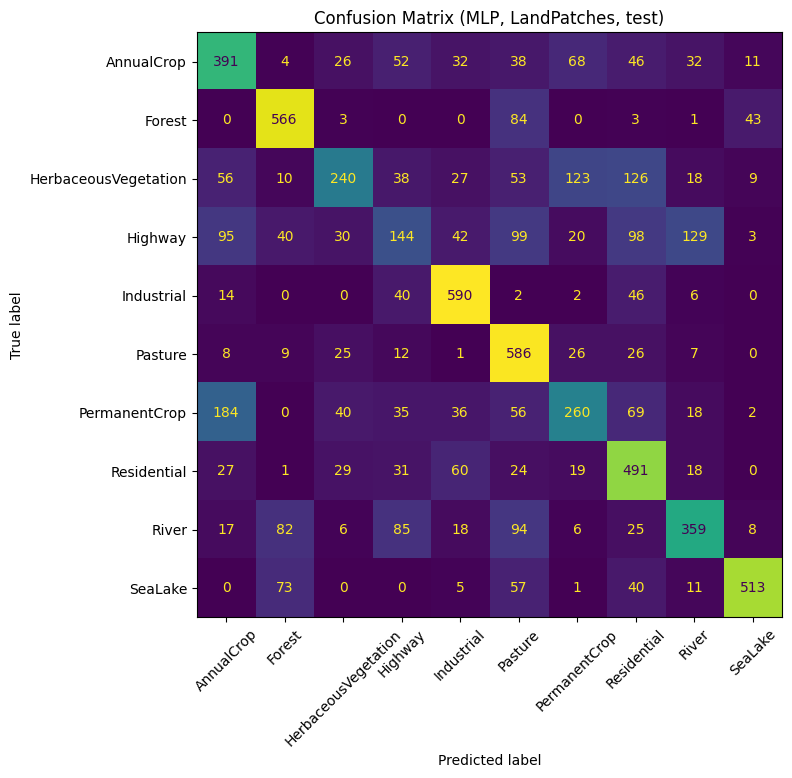

In [55]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, xticks_rotation=45, colorbar=False)
plt.title("Confusion Matrix (MLP, LandPatches, test)")
plt.tight_layout()
plt.show()


# 3. CNN pe Land Patches

1) Construim un baseline CNN pentru clasificare.
2) Comparam antrenarea fara augmentări vs. cu augmentări (Albumentations) pe aceleași grafice.


In [ ]:
import albumentations as A

tfm_noaug_64 = A.Compose([
    A.Resize(64, 64),
    A.Normalize(mean=mean_rgb.tolist(), std=std_rgb.tolist(), max_pixel_value=255.0),
])

tfm_aug_64 = A.Compose([
    A.Resize(64, 64),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(0.15, 0.15, p=0.5),
    A.Normalize(mean=mean_rgb.tolist(), std=std_rgb.tolist(), max_pixel_value=255.0),
])


In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128

train_ds_noaug = LandPatchesDataset(df[df.split=="train"], tfm_noaug_64, flatten=False)
val_ds_noaug   = LandPatchesDataset(df[df.split=="val"],   tfm_noaug_64, flatten=False)

train_ds_aug = LandPatchesDataset(df[df.split=="train"], tfm_aug_64, flatten=False)
val_ds_aug   = LandPatchesDataset(df[df.split=="val"],   tfm_noaug_64, flatten=False) 

train_loader_noaug = DataLoader(train_ds_noaug, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader_noaug   = DataLoader(val_ds_noaug,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

train_loader_aug = DataLoader(train_ds_aug, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader_aug   = DataLoader(val_ds_aug,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


In [61]:
import torch
import torch.nn as nn
import torch.optim as optim

class CNNv2(nn.Module):
    def __init__(self, num_classes, base=48, dropout=0.3):
        super().__init__()

        def block(cin, cout):
            return nn.Sequential(
                nn.Conv2d(cin, cout, 3, padding=1, bias=False),
                nn.BatchNorm2d(cout),
                nn.ReLU(inplace=True),
                nn.Conv2d(cout, cout, 3, padding=1, bias=False),
                nn.BatchNorm2d(cout),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
            )

        self.features = nn.Sequential(
            block(3, base),          # 64 -> 32
            block(base, base*2),     # 32 -> 16
            block(base*2, base*4),   # 16 -> 8
            block(base*4, base*4),   # 8 -> 4
        )

        self.pool = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(base*4, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x


In [65]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def run_epoch(model, loader, optimizer=None):
    train = optimizer is not None
    model.train(train)

    criterion = nn.CrossEntropyLoss()
    losses = []
    all_y, all_p = [], []

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        if train:
            optimizer.zero_grad()

        logits = model(x)
        loss = criterion(logits, y)

        if train:
            loss.backward()
            optimizer.step()

        losses.append(loss.item())
        preds = logits.argmax(dim=1)

        all_y.append(y.detach().cpu().numpy())
        all_p.append(preds.detach().cpu().numpy())

    all_y = np.concatenate(all_y)
    all_p = np.concatenate(all_p)

    acc = accuracy_score(all_y, all_p)
    f1  = f1_score(all_y, all_p, average="macro")
    return float(np.mean(losses)), acc, f1


def train_cnn_model(train_loader, val_loader, base=48, dropout=0.3,
                    epochs=70, lr=3e-4, weight_decay=1e-4,
                    patience=10, min_delta=1e-4):

    model = CNNv2(num_classes=num_classes, base=base, dropout=dropout).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[], "train_f1":[], "val_f1":[]}

    best_val = -1.0
    best_state = None
    bad_epochs = 0

    for ep in range(1, epochs+1):
        tr_loss, tr_acc, tr_f1 = run_epoch(model, train_loader, optimizer=optimizer)
        va_loss, va_acc, va_f1 = run_epoch(model, val_loader, optimizer=None)

        history["train_loss"].append(tr_loss); history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc);   history["val_acc"].append(va_acc)
        history["train_f1"].append(tr_f1);     history["val_f1"].append(va_f1)

        improved = (va_f1 > best_val + min_delta)
        if improved:
            best_val = va_f1
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1

        print(f"Epoch {ep:02d} | train loss {tr_loss:.3f} acc {tr_acc:.3f} f1 {tr_f1:.3f} "
              f"| val loss {va_loss:.3f} acc {va_acc:.3f} f1 {va_f1:.3f} "
              f"| bad_epochs={bad_epochs}/{patience}")

        if bad_epochs >= patience:
            print(f"Early stopping. Best val_f1={best_val:.4f}")
            break

    model.load_state_dict(best_state)
    return model, history


In [66]:
cnn_noaug_64, hist_cnn_noaug_64 = train_cnn_model(train_loader_noaug, val_loader_noaug, lr=3e-4, patience=10)


Epoch 01 | train loss 1.429 acc 0.522 f1 0.510 | val loss 2.656 acc 0.100 f1 0.018 | bad_epochs=0/10
Epoch 02 | train loss 0.941 acc 0.688 f1 0.675 | val loss 1.776 acc 0.359 f1 0.316 | bad_epochs=0/10
Epoch 03 | train loss 0.775 acc 0.734 f1 0.729 | val loss 0.858 acc 0.698 f1 0.681 | bad_epochs=0/10
Epoch 04 | train loss 0.692 acc 0.775 f1 0.773 | val loss 0.695 acc 0.771 f1 0.773 | bad_epochs=0/10
Epoch 05 | train loss 0.683 acc 0.769 f1 0.766 | val loss 0.692 acc 0.756 f1 0.750 | bad_epochs=1/10
Epoch 06 | train loss 0.610 acc 0.791 f1 0.790 | val loss 0.777 acc 0.720 f1 0.717 | bad_epochs=2/10
Epoch 07 | train loss 0.531 acc 0.823 f1 0.821 | val loss 0.661 acc 0.761 f1 0.762 | bad_epochs=3/10
Epoch 08 | train loss 0.487 acc 0.842 f1 0.840 | val loss 0.614 acc 0.792 f1 0.788 | bad_epochs=0/10
Epoch 09 | train loss 0.474 acc 0.846 f1 0.845 | val loss 0.657 acc 0.776 f1 0.775 | bad_epochs=1/10
Epoch 10 | train loss 0.473 acc 0.840 f1 0.840 | val loss 0.666 acc 0.769 f1 0.765 | bad_ep

In [67]:
cnn_aug_64,   hist_cnn_aug_64   = train_cnn_model(train_loader_aug,   val_loader_aug,   lr=3e-4, patience=10)


Epoch 01 | train loss 1.456 acc 0.478 f1 0.462 | val loss 2.915 acc 0.100 f1 0.019 | bad_epochs=0/10
Epoch 02 | train loss 1.068 acc 0.619 f1 0.611 | val loss 1.702 acc 0.386 f1 0.353 | bad_epochs=0/10
Epoch 03 | train loss 0.905 acc 0.685 f1 0.678 | val loss 0.776 acc 0.742 f1 0.733 | bad_epochs=0/10
Epoch 04 | train loss 0.824 acc 0.713 f1 0.708 | val loss 0.761 acc 0.728 f1 0.717 | bad_epochs=1/10
Epoch 05 | train loss 0.829 acc 0.710 f1 0.704 | val loss 0.965 acc 0.670 f1 0.652 | bad_epochs=2/10
Epoch 06 | train loss 0.789 acc 0.725 f1 0.720 | val loss 0.987 acc 0.659 f1 0.640 | bad_epochs=3/10
Epoch 07 | train loss 0.694 acc 0.763 f1 0.761 | val loss 0.628 acc 0.792 f1 0.793 | bad_epochs=0/10
Epoch 08 | train loss 0.649 acc 0.770 f1 0.768 | val loss 0.584 acc 0.801 f1 0.796 | bad_epochs=0/10
Epoch 09 | train loss 0.599 acc 0.798 f1 0.797 | val loss 0.893 acc 0.734 f1 0.728 | bad_epochs=1/10
Epoch 10 | train loss 0.666 acc 0.773 f1 0.771 | val loss 0.693 acc 0.764 f1 0.765 | bad_ep

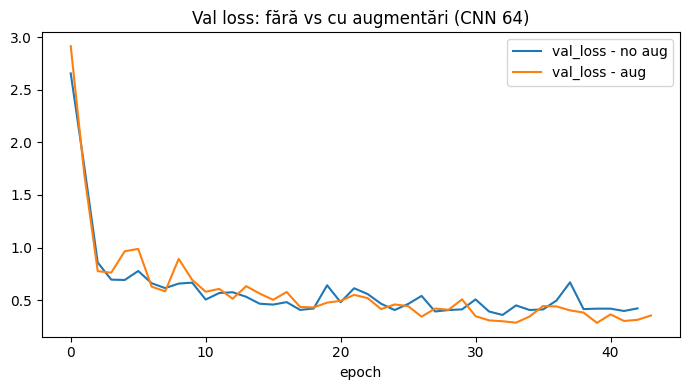

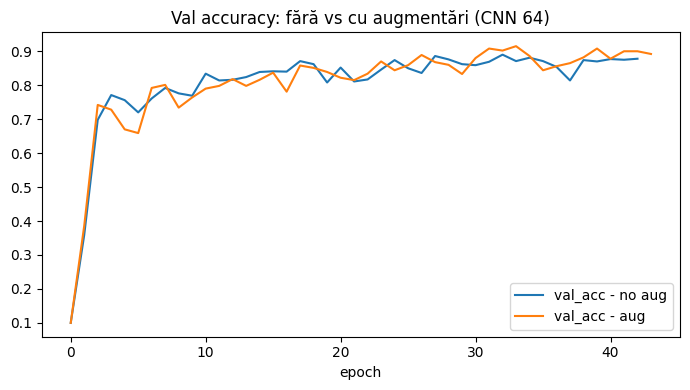

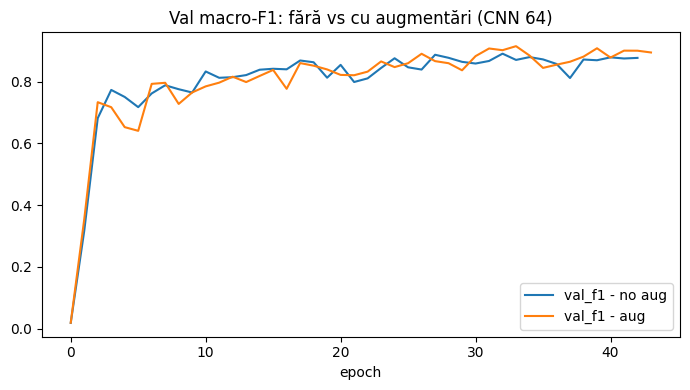

In [68]:
import matplotlib.pyplot as plt

def plot_compare(hist1, hist2, key, title):
    plt.figure(figsize=(7,4))
    plt.plot(hist1[key], label=f"{key} - no aug")
    plt.plot(hist2[key], label=f"{key} - aug")
    plt.title(title)
    plt.xlabel("epoch")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_compare(hist_cnn_noaug_64, hist_cnn_aug_64, "val_loss", "Val loss: fără vs cu augmentări (CNN 64)")
plot_compare(hist_cnn_noaug_64, hist_cnn_aug_64, "val_acc",  "Val accuracy: fără vs cu augmentări (CNN 64)")
plot_compare(hist_cnn_noaug_64, hist_cnn_aug_64, "val_f1",   "Val macro-F1: fără vs cu augmentări (CNN 64)")


Pregatim alte modele fara pretrain ca sa avem o baza egala de comparatie
- resize la 96 ca la Imagebits
- base 64 in arhitectura ca la Imagebits

In [78]:
import albumentations as A

tfm_noaug_96 = A.Compose([
    A.Resize(96, 96),
    A.Normalize(mean=mean_rgb.tolist(), std=std_rgb.tolist(), max_pixel_value=255.0),
])

tfm_aug_96 = A.Compose([
    A.Resize(96, 96),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(0.15, 0.15, p=0.5),
    A.Normalize(mean=mean_rgb.tolist(), std=std_rgb.tolist(), max_pixel_value=255.0),
])


In [79]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128

train_ds_96 = LandPatchesDataset(df[df.split=="train"], tfm_aug_96,   flatten=False)
val_ds_96   = LandPatchesDataset(df[df.split=="val"],   tfm_noaug_96, flatten=False)
test_ds_96  = LandPatchesDataset(df[df.split=="test"],  tfm_noaug_96, flatten=False)

train_loader_96 = DataLoader(train_ds_96, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader_96   = DataLoader(val_ds_96,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader_96  = DataLoader(test_ds_96,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


Antrenam un model si cu base 64 in arhitectura dar cu size clasic de 64, pentru a putea compara cele 2 modele from scratch intre ele

In [81]:
cnn_scratch_64_base64, hist_scratch_64_base64 = train_cnn_model(
    train_loader_aug, val_loader_aug,
    base=64, dropout=0.3,
    epochs=70, lr=3e-4, weight_decay=1e-4,
    patience=10, min_delta=1e-4
)


Epoch 01 | train loss 1.359 acc 0.530 f1 0.515 | val loss 3.349 acc 0.100 f1 0.018 | bad_epochs=0/10
Epoch 02 | train loss 0.994 acc 0.637 f1 0.630 | val loss 1.928 acc 0.353 f1 0.286 | bad_epochs=0/10
Epoch 03 | train loss 0.918 acc 0.673 f1 0.668 | val loss 1.068 acc 0.625 f1 0.578 | bad_epochs=0/10
Epoch 04 | train loss 0.846 acc 0.707 f1 0.702 | val loss 0.736 acc 0.746 f1 0.742 | bad_epochs=0/10
Epoch 05 | train loss 0.730 acc 0.748 f1 0.744 | val loss 0.683 acc 0.762 f1 0.752 | bad_epochs=0/10
Epoch 06 | train loss 0.769 acc 0.731 f1 0.728 | val loss 0.787 acc 0.716 f1 0.705 | bad_epochs=1/10
Epoch 07 | train loss 0.724 acc 0.739 f1 0.737 | val loss 0.850 acc 0.717 f1 0.706 | bad_epochs=2/10
Epoch 08 | train loss 0.717 acc 0.748 f1 0.746 | val loss 0.661 acc 0.780 f1 0.778 | bad_epochs=0/10
Epoch 09 | train loss 0.652 acc 0.765 f1 0.762 | val loss 0.587 acc 0.804 f1 0.806 | bad_epochs=0/10
Epoch 10 | train loss 0.601 acc 0.791 f1 0.789 | val loss 0.553 acc 0.823 f1 0.820 | bad_ep

In [82]:
best_val_f1 = max(hist_scratch_64_base64["val_f1"])
best_epoch  = int(np.argmax(hist_scratch_64_base64["val_f1"])) + 1
print(f"Best val_f1 = {best_val_f1:.4f} @ epoch {best_epoch}")


Best val_f1 = 0.9381 @ epoch 63


In [80]:
cnn_scratch_96, hist_scratch_96 = train_cnn_model(
    train_loader_96, val_loader_96,
    base=64, dropout=0.3,
    epochs=70, lr=3e-4, weight_decay=1e-4,
    patience=10
)


Epoch 01 | train loss 1.542 acc 0.462 f1 0.449 | val loss 2.654 acc 0.124 f1 0.048 | bad_epochs=0/10
Epoch 02 | train loss 1.125 acc 0.624 f1 0.616 | val loss 2.009 acc 0.292 f1 0.218 | bad_epochs=0/10
Epoch 03 | train loss 0.961 acc 0.681 f1 0.676 | val loss 0.971 acc 0.641 f1 0.623 | bad_epochs=0/10
Epoch 04 | train loss 0.876 acc 0.710 f1 0.702 | val loss 0.777 acc 0.742 f1 0.744 | bad_epochs=0/10
Epoch 05 | train loss 0.822 acc 0.718 f1 0.714 | val loss 0.687 acc 0.771 f1 0.768 | bad_epochs=0/10
Epoch 06 | train loss 0.787 acc 0.726 f1 0.723 | val loss 0.699 acc 0.771 f1 0.760 | bad_epochs=1/10
Epoch 07 | train loss 0.696 acc 0.764 f1 0.762 | val loss 0.639 acc 0.792 f1 0.788 | bad_epochs=0/10
Epoch 08 | train loss 0.661 acc 0.773 f1 0.771 | val loss 0.782 acc 0.711 f1 0.712 | bad_epochs=1/10
Epoch 09 | train loss 0.614 acc 0.788 f1 0.787 | val loss 0.615 acc 0.797 f1 0.795 | bad_epochs=0/10
Epoch 10 | train loss 0.605 acc 0.787 f1 0.786 | val loss 0.647 acc 0.789 f1 0.792 | bad_ep

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def _trim(h1, h2, key):
    n = min(len(h1[key]), len(h2[key]))
    return np.array(h1[key][:n]), np.array(h2[key][:n])

def best_val_f1(hist):
    v = np.array(hist["val_f1"])
    return float(v.max()), int(v.argmax()) + 1

def plot_compare_metric(hist_a, name_a, hist_b, name_b, key="val_f1", title=None, smooth=0):
    a, b = _trim(hist_a, hist_b, key)
    x = np.arange(1, len(a) + 1)

    if smooth and smooth > 1:
        def ma(y, w):
            if len(y) < w: 
                return y
            return np.convolve(y, np.ones(w)/w, mode="valid")
        a_s = ma(a, smooth)
        b_s = ma(b, smooth)
        x_s = np.arange(1, len(a_s) + 1)
        plt.figure(figsize=(7,4))
        plt.plot(x_s, a_s, label=f"{name_a} (smoothed)")
        plt.plot(x_s, b_s, label=f"{name_b} (smoothed)")
    else:
        plt.figure(figsize=(7,4))
        plt.plot(x, a, label=name_a)
        plt.plot(x, b, label=name_b)

    plt.xlabel("epoch")
    plt.ylabel(key)
    plt.title(title if title else f"Comparison: {key}")
    plt.legend()
    plt.tight_layout()
    plt.show()

def summarize_two(hist_a, name_a, hist_b, name_b):
    a_best, a_ep = best_val_f1(hist_a)
    b_best, b_ep = best_val_f1(hist_b)
    print(f"{name_a}: best val_f1={a_best:.4f} @ epoch {a_ep}")
    print(f"{name_b}: best val_f1={b_best:.4f} @ epoch {b_ep}")


- Comparatii intre modele

1) Augmentare + size 64x64, base 48 vs base 64

Scratch 64 base48 (aug): best val_f1=0.9147 @ epoch 34
Scratch 64 base64 (aug): best val_f1=0.9381 @ epoch 63


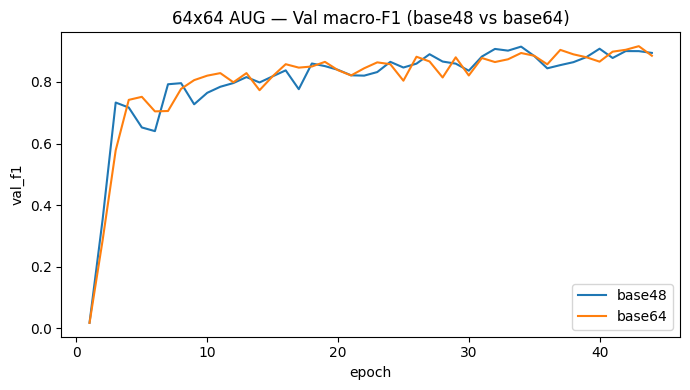

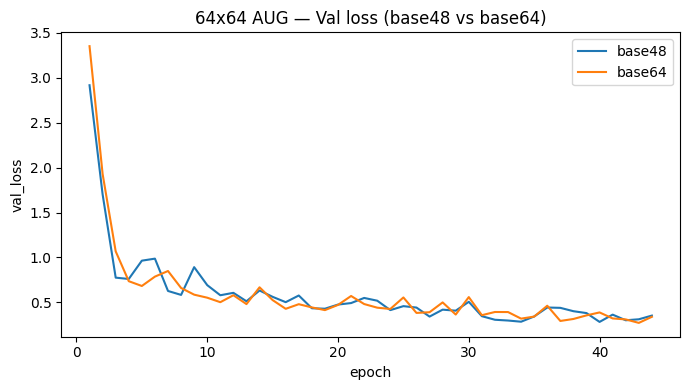

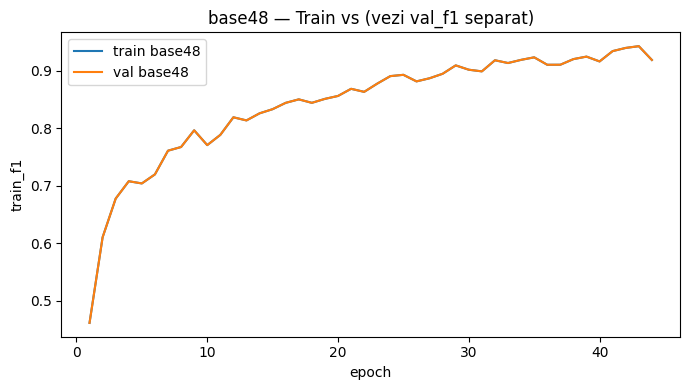

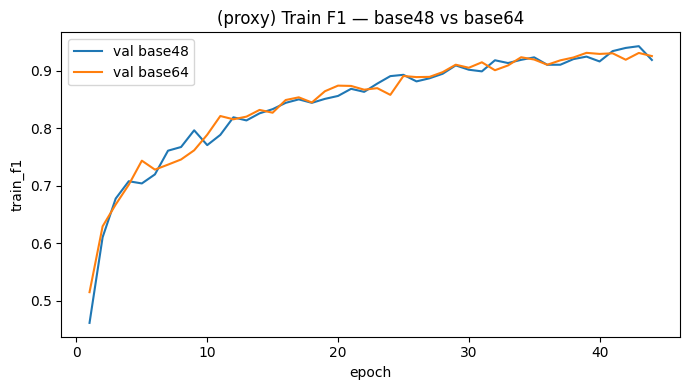

In [87]:
summarize_two(hist_cnn_aug_64, "Scratch 64 base48 (aug)", 
              hist_scratch_64_base64, "Scratch 64 base64 (aug)")

plot_compare_metric(hist_cnn_aug_64, "base48", hist_scratch_64_base64, "base64",
                    key="val_f1", title="64x64 AUG — Val macro-F1 (base48 vs base64)")

plot_compare_metric(hist_cnn_aug_64, "base48", hist_scratch_64_base64, "base64",
                    key="val_loss", title="64x64 AUG — Val loss (base48 vs base64)")

plot_compare_metric(hist_cnn_aug_64, "val base48", hist_scratch_64_base64, "val base64",
                    key="train_f1", title="(proxy) Train F1 — base48 vs base64")


2) Augmentare + base 64, size 64 vs size 96

Scratch 64 base64 (aug): best val_f1=0.9381 @ epoch 63
Scratch 96 base64 (aug): best val_f1=0.9333 @ epoch 56


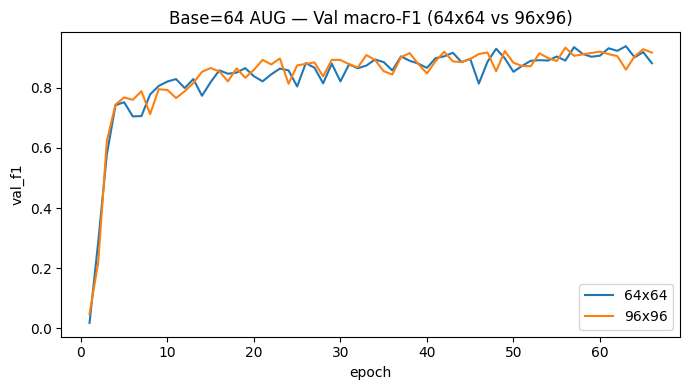

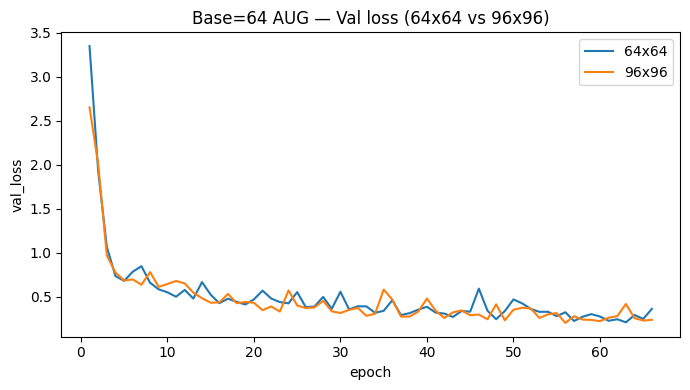

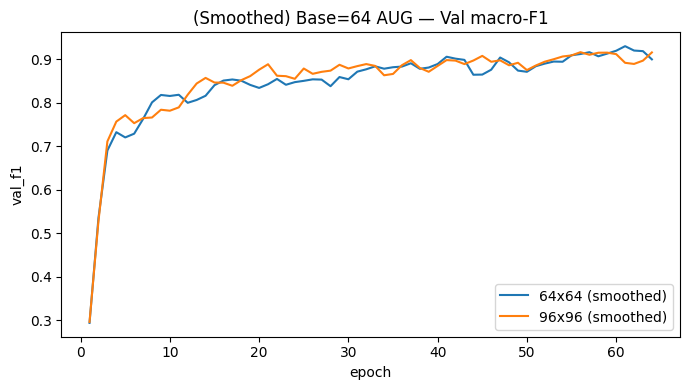

In [88]:
summarize_two(hist_scratch_64_base64, "Scratch 64 base64 (aug)", 
              hist_scratch_96, "Scratch 96 base64 (aug)")

plot_compare_metric(hist_scratch_64_base64, "64x64", hist_scratch_96, "96x96",
                    key="val_f1", title="Base=64 AUG — Val macro-F1 (64x64 vs 96x96)")

plot_compare_metric(hist_scratch_64_base64, "64x64", hist_scratch_96, "96x96",
                    key="val_loss", title="Base=64 AUG — Val loss (64x64 vs 96x96)")

plot_compare_metric(hist_scratch_64_base64, "64x64", hist_scratch_96, "96x96",
                    key="val_f1", title="(Smoothed) Base=64 AUG — Val macro-F1")


Alegem configuratia cea mai buna pentru a testa: modelul cu size 64x64 si base 64 ca hiperparametru al arhitecturii

In [83]:
@torch.no_grad()
def eval_with_preds(model, loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()

    losses = []
    all_y, all_p = [], []

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        losses.append(loss.item())
        preds = logits.argmax(dim=1)

        all_y.append(y.cpu().numpy())
        all_p.append(preds.cpu().numpy())

    y_true = np.concatenate(all_y)
    y_pred = np.concatenate(all_p)

    loss = float(np.mean(losses))
    acc  = accuracy_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred, average="macro")
    return loss, acc, f1, y_true, y_pred


test_ds_64 = LandPatchesDataset(df[df.split=="test"], tfm_noaug_64, flatten=False)
test_loader_64 = DataLoader(test_ds_64, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

best_cnn_64 = cnn_scratch_64_base64

test_loss, test_acc, test_f1, y_true, y_pred = eval_with_preds(best_cnn_64, test_loader_64)
print(f"TEST (CNN 64) | loss {test_loss:.3f} acc {test_acc:.4f} macro-F1 {test_f1:.4f}")


TEST (CNN 64) | loss 0.230 acc 0.9257 macro-F1 0.9259


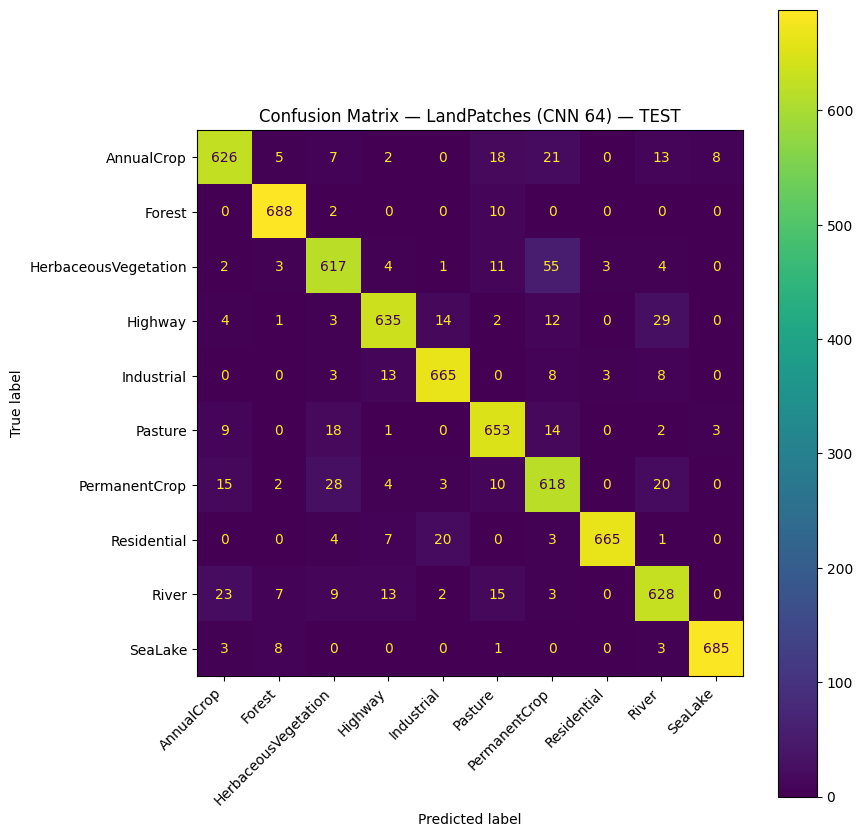

In [84]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(9, 9))
disp.plot(ax=ax, cmap="viridis", colorbar=True, values_format="d")
ax.set_title("Confusion Matrix — LandPatches (CNN 64) — TEST")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.metrics import f1_score

support = cm.sum(axis=1)
per_class_acc = np.divide(cm.diagonal(), support, out=np.zeros_like(support, dtype=float), where=support!=0)

per_class_f1 = f1_score(y_true, y_pred, average=None, labels=list(range(len(class_names))))

df_perclass = pd.DataFrame({
    "class": class_names,
    "acc_per_class": per_class_acc,
    "f1_per_class": per_class_f1,
    "support": support
}).sort_values("f1_per_class")  

df_perclass


class  acc_per_class  f1_per_class  support
6         PermanentCrop       0.882857      0.861925      700
2  HerbaceousVegetation       0.881429      0.887132      700
8                 River       0.897143      0.892045      700
0            AnnualCrop       0.894286      0.905933      700
5               Pasture       0.932857      0.919718      700
3               Highway       0.907143      0.920957      700
4            Industrial       0.950000      0.946619      700
7           Residential       0.950000      0.970095      700
1                Forest       0.982857      0.973126      700
9               SeaLake       0.978571      0.981375      700

# 3.1 CNN pe Land Patches cu fine tuning pe Imagebits

In [ ]:
import torch
from pathlib import Path

CKPT_PATH = Path("/kaggle/input/pretrained-imagebits/cnn_imagebits_best.pth")  

ckpt = torch.load(CKPT_PATH, map_location="cpu")
mean_ib = ckpt["mean_rgb"]
std_ib  = ckpt["std_rgb"]

tfm_noaug_96 = A.Compose([
    A.Resize(96, 96),
    A.Normalize(mean=mean_rgb.tolist(), std=std_rgb.tolist(), max_pixel_value=255.0),
])

tfm_aug_96 = A.Compose([
    A.Resize(96, 96),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(0.15, 0.15, p=0.5),
    A.Normalize(mean=mean_rgb.tolist(), std=std_rgb.tolist(), max_pixel_value=255.0),
])


In [90]:
train_ds_ft = LandPatchesDataset(df[df.split=="train"], tfm_aug_96, flatten=False)
val_ds_ft   = LandPatchesDataset(df[df.split=="val"],   tfm_noaug_96, flatten=False)

train_loader_ft = DataLoader(train_ds_ft, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader_ft   = DataLoader(val_ds_ft,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_ds_ft = LandPatchesDataset(df[df.split=="test"], tfm_noaug_96, flatten=False)
test_loader_ft = DataLoader(test_ds_ft, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


In [ ]:
def load_pretrained_backbone(model, ckpt_state):
    sd = {k: v for k, v in ckpt_state.items() if not k.startswith("classifier")}
    missing, unexpected = model.load_state_dict(sd, strict=False)
    print("Loaded backbone.")
    print("Missing keys (ok, head):", [k for k in missing if k.startswith("classifier")][:5], "...")
    print("Unexpected keys:", unexpected)

def finetune_two_stage(model, train_loader, val_loader,
                       head_lr=1e-3, ft_backbone_lr=1e-4, ft_head_lr=5e-4,
                       weight_decay=1e-4, stage1_epochs=5,
                       epochs=50, patience=10):

    for p in model.features.parameters():
        p.requires_grad = False

    opt1 = optim.AdamW(model.classifier.parameters(), lr=head_lr, weight_decay=weight_decay)

    print("Stage 1 (freeze backbone) ...")
    best_val = -1.0
    best_state = None
    bad = 0

    for ep in range(1, stage1_epochs+1):
        tr_loss, tr_acc, tr_f1 = run_epoch(model, train_loader, optimizer=opt1)
        va_loss, va_acc, va_f1 = run_epoch(model, val_loader, optimizer=None)

        if va_f1 > best_val:
            best_val = va_f1
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1

        print(f"[S1] Epoch {ep:02d} | val f1 {va_f1:.3f}")

    model.load_state_dict(best_state)

    for p in model.features.parameters():
        p.requires_grad = True

    opt2 = optim.AdamW([
        {"params": model.features.parameters(), "lr": ft_backbone_lr},
        {"params": model.classifier.parameters(), "lr": ft_head_lr},
    ], weight_decay=weight_decay)

    print("Stage 2 (unfreeze, fine-tune) ...")
    history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[], "train_f1":[], "val_f1":[]}

    best_val = -1.0
    best_state = None
    bad = 0

    for ep in range(1, epochs+1):
        tr_loss, tr_acc, tr_f1 = run_epoch(model, train_loader, optimizer=opt2)
        va_loss, va_acc, va_f1 = run_epoch(model, val_loader, optimizer=None)

        history["train_loss"].append(tr_loss); history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc);   history["val_acc"].append(va_acc)
        history["train_f1"].append(tr_f1);     history["val_f1"].append(va_f1)

        if va_f1 > best_val + 1e-4:
            best_val = va_f1
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1

        print(f"[S2] Epoch {ep:02d} | train f1 {tr_f1:.3f} | val f1 {va_f1:.3f} | bad={bad}/{patience}")

        if bad >= patience:
            print("Early stopping. Best val_f1 =", best_val)
            break

    model.load_state_dict(best_state)
    return model, history


In [ ]:
num_lp_classes = len(label_to_idx)  

cnn_ft = CNNv2(num_classes=num_lp_classes, base=64, dropout=0.3).to(device)

load_pretrained_backbone(cnn_ft, ckpt["model_state_dict"])

cnn_ft, hist_ft = finetune_two_stage(
    cnn_ft, train_loader_ft, val_loader_ft,
    head_lr=1e-3, ft_backbone_lr=1e-4, ft_head_lr=5e-4,
    stage1_epochs=5, epochs=50, patience=10
)



Loaded backbone.
Missing keys (ok, head): ['classifier.2.weight', 'classifier.2.bias'] ...
Unexpected keys: []
Stage 1 (freeze backbone) ...
[S1] Epoch 01 | val f1 0.298
[S1] Epoch 02 | val f1 0.452
[S1] Epoch 03 | val f1 0.477
[S1] Epoch 04 | val f1 0.473
[S1] Epoch 05 | val f1 0.510
Stage 2 (unfreeze, fine-tune) ...
[S2] Epoch 01 | train f1 0.614 | val f1 0.711 | bad=0/10
[S2] Epoch 02 | train f1 0.741 | val f1 0.780 | bad=0/10
[S2] Epoch 03 | train f1 0.779 | val f1 0.815 | bad=0/10
[S2] Epoch 04 | train f1 0.824 | val f1 0.844 | bad=0/10
[S2] Epoch 05 | train f1 0.825 | val f1 0.869 | bad=0/10
[S2] Epoch 06 | train f1 0.860 | val f1 0.842 | bad=1/10
[S2] Epoch 07 | train f1 0.872 | val f1 0.872 | bad=0/10
[S2] Epoch 08 | train f1 0.866 | val f1 0.891 | bad=0/10
[S2] Epoch 09 | train f1 0.896 | val f1 0.880 | bad=1/10
[S2] Epoch 10 | train f1 0.894 | val f1 0.879 | bad=2/10
[S2] Epoch 11 | train f1 0.897 | val f1 0.880 | bad=3/10
[S2] Epoch 12 | train f1 0.905 | val f1 0.903 | bad=0

In [95]:
test_loss_ft, test_acc_ft, test_f1_ft, y_true, y_pred = eval_with_preds(cnn_ft, test_loader_ft)
print(f"TEST (FT 96) | loss {test_loss_ft:.3f} acc {test_acc_ft:.4f} macro-F1 {test_f1_ft:.4f}")

TEST (FT 96) | loss 0.223 acc 0.9279 macro-F1 0.9279


In [93]:
train_paths = set(df[df.split=="train"]["path"])
val_paths   = set(df[df.split=="val"]["path"])
test_paths  = set(df[df.split=="test"]["path"])
print(len(train_paths & val_paths), len(train_paths & test_paths), len(val_paths & test_paths))


0 0 0


Pentru a compara modelul fine tuned cu cel fara preantrenare, vom calcula valoarea dupa test a modelului from scratch cu size 96x96 si base 64, ca aceste valori sa fie identice pentru cele doua variante

In [96]:
test_loss_s, test_acc_s, test_f1_s, _, _ = eval_with_preds(cnn_scratch_96, test_loader_96)
print(f"TEST (Scratch 96, base=64) | loss {test_loss_s:.3f} acc {test_acc_s:.4f} macro-F1 {test_f1_s:.4f}")

TEST (Scratch 96, base=64) | loss 0.239 acc 0.9200 macro-F1 0.9195


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np

idx_to_label = {v:k for k,v in label_to_idx.items()}
class_names = [idx_to_label[i] for i in range(num_classes)]

def per_class_table(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    acc_per_class = cm.diagonal() / cm.sum(axis=1)

    rep = classification_report(
        y_true, y_pred,
        labels=list(range(num_classes)),
        target_names=class_names,
        output_dict=True,
        zero_division=0
    )
    rows = []
    for i, name in enumerate(class_names):
        rows.append({
            "class": name,
            "support": cm.sum(axis=1)[i],
            "acc_per_class": acc_per_class[i],
            "precision": rep[name]["precision"],
            "recall": rep[name]["recall"],
            "f1": rep[name]["f1-score"],
        })
    return pd.DataFrame(rows).sort_values("f1")

_, _, _, y_true_ft, y_pred_ft = eval_with_preds(cnn_ft, test_loader_ft)
df_ft = per_class_table(y_true_ft, y_pred_ft)
display(df_ft)

_, _, _, y_true_s, y_pred_s = eval_with_preds(cnn_scratch_96, test_loader_96)
df_s = per_class_table(y_true_s, y_pred_s)
display(df_s)


class  support  acc_per_class  precision    recall        f1
6         PermanentCrop      700       0.927143   0.840674  0.927143  0.881793
8                 River      700       0.851429   0.947536  0.851429  0.896915
2  HerbaceousVegetation      700       0.877143   0.920540  0.877143  0.898317
3               Highway      700       0.904286   0.900427  0.904286  0.902352
0            AnnualCrop      700       0.871429   0.959119  0.871429  0.913174
5               Pasture      700       0.960000   0.881890  0.960000  0.919289
4            Industrial      700       0.977143   0.907162  0.977143  0.940853
7           Residential      700       0.950000   0.991058  0.950000  0.970095
1                Forest      700       0.971429   0.974212  0.971429  0.972818
9               SeaLake      700       0.988571   0.977401  0.988571  0.982955

class  support  acc_per_class  precision    recall        f1
3               Highway      700       0.787143   0.973498  0.787143  0.870458
2  HerbaceousVegetation      700       0.914286   0.847682  0.914286  0.879725
6         PermanentCrop      700       0.865714   0.908546  0.865714  0.886613
8                 River      700       0.900000   0.893617  0.900000  0.896797
0            AnnualCrop      700       0.928571   0.878378  0.928571  0.902778
5               Pasture      700       0.895714   0.944277  0.895714  0.919355
4            Industrial      700       0.968571   0.901596  0.968571  0.933884
7           Residential      700       0.984286   0.922356  0.984286  0.952315
1                Forest      700       0.977143   0.964739  0.977143  0.970901
9               SeaLake      700       0.978571   0.985612  0.978571  0.982079

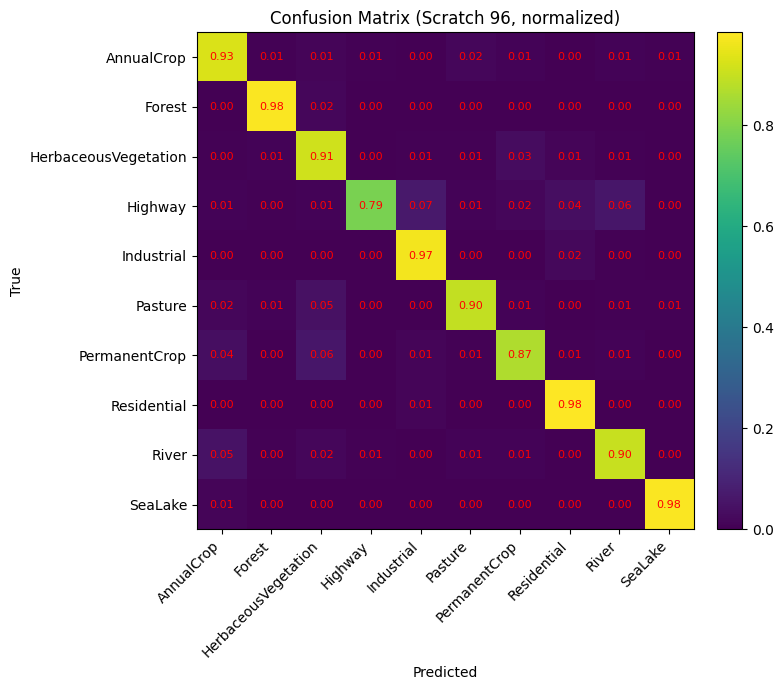

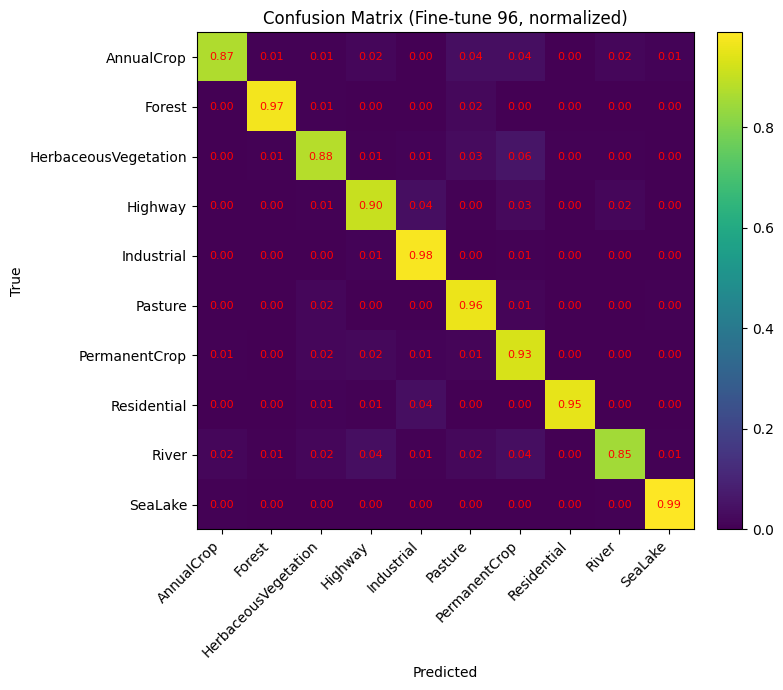

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    cm_norm = cm / cm.sum(axis=1, keepdims=True)

    fig, ax = plt.subplots(figsize=(8, 7))
    im = ax.imshow(cm_norm, interpolation="nearest")  

    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    ax.set_xticks(np.arange(num_classes))
    ax.set_yticks(np.arange(num_classes))
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticklabels(class_names)

    for i in range(num_classes):
        for j in range(num_classes):
            ax.text(j, i, f"{cm_norm[i,j]:.2f}", ha="center", va="center", fontsize=8, color="red")

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

plot_cm(y_true_s, y_pred_s, "Confusion Matrix (Scratch 96, normalized)")
plot_cm(y_true_ft, y_pred_ft, "Confusion Matrix (Fine-tune 96, normalized)")


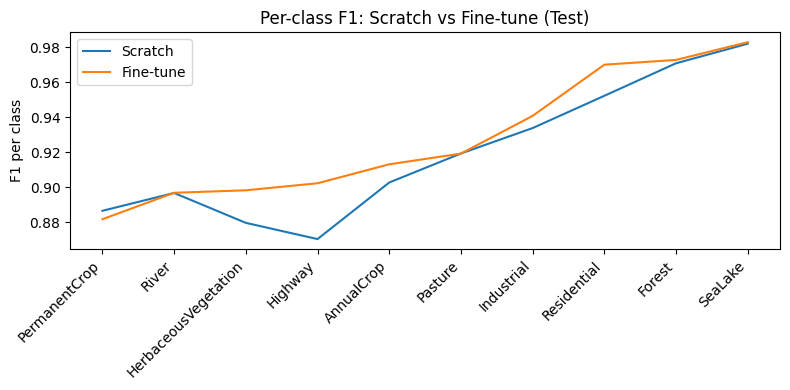

In [101]:
import matplotlib.pyplot as plt

df_cmp = df_s[["class","f1"]].merge(df_ft[["class","f1"]], on="class", suffixes=("_scratch","_ft"))
df_cmp = df_cmp.sort_values("f1_ft")

plt.figure(figsize=(8,4))
plt.plot(df_cmp["f1_scratch"].values, label="Scratch")
plt.plot(df_cmp["f1_ft"].values, label="Fine-tune")
plt.xticks(range(len(df_cmp)), df_cmp["class"], rotation=45, ha="right")
plt.ylabel("F1 per class")
plt.title("Per-class F1: Scratch vs Fine-tune (Test)")
plt.legend()
plt.tight_layout()
plt.show()
